## Initialize and import

In [0]:
colab = True

In [0]:
import os
import math
import numpy as np
import numpy.ma as ma
import pandas as pd
from time import time, sleep
import matplotlib.pyplot as plt
from skimage.measure import LineModelND, ransac
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [0]:
# can be removed but here for testing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 10.0)

In [0]:
data_ids = ['1ROwe7mg7bdnCdMN6oEyULyWFDH192EQS', # capture1
            '1FJmKxbfjTUn2d3V8am2GPN4jTlDsrgP-', # capture2
            '1t4Ax303itok3L8i2BmH1vvu8oPmg2Ei2', # capture3
            '1AF_ED0R2J-gp_q9rajptRpsbfK6baabF', # scan-data-Room1
            '1F8W6Gmkc95Z9z836AxmWaSYdDJ0S3LsF', # scan-data-Room2
            '1myqcdiu4IkGxUWKAvi6hD8KIJzybzHdp', # scan-data-Room1-upto-50times
            '1UzzoG408Vkpy2Y6EfMkh9LIaSaJae8P4'] # scan-data-Room2-upto-50times

In [6]:
for id in data_ids:
    os.system('gdown https://drive.google.com/uc?id=%s' % id)
!ls

capture1.csv  sample_data		scan-data-Room1-upto-50times.csv
capture2.csv  scan-data-for-Room-1.csv	scan-data-Room2-upto-50times.csv
capture3.csv  scan-data-for-Room-2.csv




```
# This is formatted as code
```

## Utility functions

In [0]:
# read data csv
def read_capture(file_path, verbose=True):
    df = pd.read_csv(file_path,delimiter=',',header=None)
    angle = df.values[:,0]
    distance = df.values[:,1]
    cartesian = [( r*math.sin(phi*math.pi/180),r*math.cos(phi*math.pi/180)) for r, phi in zip(distance, angle)]

    x, y = map(list, zip(*cartesian))
    x = np.array(x)
    y = np.array(y)

    x_data = x.reshape(-1, 1)
    y_data = y.reshape(-1, 1)

    plt.plot(x_data, y_data, '.', color = 'grey')
    plt.title('All Data')
    plt.axis('equal')
    plt.show()
    
    return x_data, y_data

In [0]:
# get best RANSAC fit and compute angle
def compute_ransac_angles(x_data, y_data, n_win=10, n_trials=100):

    # storage of angles
    angs = []

    startTime = time()

    # loop through data
    # TODO: Performance edge cases. It would be unfortunate to start our data stream at a corner
    for idx in range(len(y_data)-n_win):

        # cut window
        x_curs = x_data[idx:idx+n_win]
        y_curs = y_data[idx:idx+n_win]


        # setup RANSAC
        model_LMND = LineModelND()
        points = np.column_stack([x_curs, y_curs])
        model_LMND.estimate(points)

        # RANSAC
        model_RANSAC, _ = ransac(points, LineModelND, min_samples=2, residual_threshold=5, max_trials=n_trials)

        # compute lines
        x_range = np.array([x_curs.min(), x_curs.max()])
        y_range = model_LMND.predict_y(x_range)
        y_range_RANSAC = model_RANSAC.predict_y(x_range)
        slope = (y_range_RANSAC[1] - y_range_RANSAC[0])/(x_range[1]- x_range[0])

        # TODO: We need a better way to recognize unseen walls.

        # store angle
        angs.append(np.arctan(slope))   

    angs = np.array(angs)
    angs[angs > 1.5] = angs[angs > 1.5]-np.pi

    print('Total time: %fs' % (time()-startTime))
    
    return angs

In [0]:
# search for corners from angles (DEPRECATED)
def find_corners_from_angles(angs, x_data, y_data):

    # corners based on thersholding
    corner_idx = np.abs(np.diff(angs)) > 0.8

    # arbitrary offset indexing
    # TODO: Use other heuristics to determine centering!
    offset = -1

    n_win = len(x_data) - len(corner_idx)

    # set up logical indexing window
    corner_idx = np.concatenate(([False]*(int(n_win/2)-offset), corner_idx, [False]*(int(n_win/2)+1+offset)))

    # retrieve corner guesses
    x_corner = x_data[corner_idx]
    y_corner = y_data[corner_idx]

    # plot corner point guesses

    plt.plot(x_data, y_data, '.')
    plt.plot(x_corner, y_corner, 'o')
    plt.title('Corner Guessing')
    plt.legend(['Raw data', 'Corner guess'])
    plt.axis('equal')
    plt.show()

In [0]:
def distance(x1,y1,x2,y2):
    # compute cartesian distance
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [0]:
# compute intersection of two lines
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [0]:
# pad array
def fill_arr(arr, val, n, offset=0):
    fill_n = n - len(arr)
    ret = np.concatenate(([val]*int(np.floor(fill_n/2)+offset), arr, [val]*int(np.ceil(fill_n/2)-offset)))
    return ret

In [0]:
# look for angle regions where we are transitioning from one wall to another
def search_transition_regions(angs, slide_win=40, angle_threshold=0.8, count_thresh=1, verbose=False):
    trans_idx = np.abs(np.diff(angs)) > angle_threshold
    trans_slide = []
    
    # loop to find regions of high counts of transitions
    for idx in range(len(trans_idx)-slide_win):        
        trans_slide.append(np.sum(trans_idx[idx:(idx+slide_win)])>count_thresh)

    if verbose:
        plt.plot(trans_idx, '.')
        plt.plot(trans_slide)
        plt.legend(['Transition indicator', 'Transition moving OR'])
        plt.show()
        
    return trans_slide

In [0]:
# clean the wall predictions using RANSAC
def compile_walls(trans_slide, x_data, y_data, n_trials=100, verbose=False):
    # the idea of this function is to compute RANSAC lines on stable regions (walls) as opposed to unstable corners

    offset = 1

    # pad array to full data length
    trans_fill = fill_arr(trans_slide, False, len(x_data), offset=offset)

    # pairwise XOR (exclusive or), looking for changes in transition regions
    t_idx = [trans_fill[i] != trans_fill[i+1] for i in range(len(trans_fill)-1)]

    # reassemble these segment points 
    seg_pts = np.concatenate(([0], np.where(t_idx)[0], [len(x_data)-1]))

    it = iter(seg_pts)
    wall_lines = []

    # loop through wall segments (two points at a time as a line needs two points)
    for p1 in it:
        p2 = next(it)

        # cut window
        x_curs = x_data[p1:p2]
        y_curs = y_data[p1:p2]

        # ignore small segments
        if len(x_curs) < 5:
            continue

        # setup RANSAC
        model_LMND = LineModelND()
        points = np.column_stack([x_curs, y_curs])
        model_LMND.estimate(points)

        # RANSAC
        model_RANSAC, _ = ransac(points, LineModelND, min_samples=2, residual_threshold=5, max_trials=n_trials)

        # compute lines
        x_range = np.array([x_curs.min(), x_curs.max()])
        y_range = model_LMND.predict_y(x_range)
        y_range_RANSAC = model_RANSAC.predict_y(x_range)
        slope = (y_range_RANSAC[1] - y_range_RANSAC[0])/(x_range[1]- x_range[0])
        
        y_range_robust = model_RANSAC.predict_y(x_range)
        k = (y_range_robust[1] - y_range_robust[0])/(x_range[1]- x_range[0])

        m = y_range_robust[0] - k*x_range[0]
        x0 = (y_curs.min() - m)/k
        x1 = (y_curs.max() - m)/k
        x_range_y = np.array([x0, x1])
        y_range_robust_y = model_RANSAC.predict_y(x_range_y)
        ww = (y_range_robust_y[1] - y_range_robust_y[0]) / (x_range_y[1] - x_range_y[0])

        if (distance(x_range[0], y_range_robust[0], x_range[1], y_range_robust[1]) <
        distance(x_range_y[0], y_range_robust_y[0], x_range_y[1], y_range_robust_y[1])):            
            x_range_r = x_range
            y_range_r = y_range_robust
        else:
            plt.plot(x_range_y, y_range_robust_y, '-r', label='Robust line model')
            x_range_r = x_range_y
            y_range_r = y_range_robust_y
        
        # what is the absolute distance the wall spans?
        x_span = np.abs(x_range_r[1] - x_range_r[0])
        y_span = np.abs(y_range_r[1] - y_range_r[0])

        if verbose:
            plt.scatter(x_data, y_data)
            plt.scatter(x_curs, y_curs)
            plt.plot(x_range_r, y_range_r, '-r', label='Robust line model')
            plt.axis('equal')
            plt.show()
            print('x_span: %f, y_span: %f' % (x_span, y_span))

        # do not record if span is too small (tiny walls can be unstable)
        if x_span < 200 and y_span < 200:
            continue

        # record wall line points (these are arbitrary and are not end points!)
        p1 = np.array((x_range_r[0], y_range_r[0]))
        p2 = np.array((x_range_r[1], y_range_r[1]))
        wall_lines.append((p1, p2))
            
    wall_lines = np.array(wall_lines)
    return wall_lines

In [0]:
def get_slope(p1, p2):
    return (p2[1]-p1[1]) / (p2[0]-p1[0])

In [0]:
# get corners from walls
def get_wall_corners(wall_lines):
    sects = []
    for i in range(len(wall_lines)-1):
        l1 = wall_lines[i]
        l2 = wall_lines[i+1]
        m1 = get_slope(l1[0], l1[1])
        m2 = get_slope(l2[0], l2[1])
        if np.abs(m1-m2) < 0.1:
            continue
        sect = line_intersection(l2, l1)
        sects.append(sect)
    sects = np.array(sects)
    return sects

In [0]:
# plot a line
def plot_line(ll, tag_append='r'):
    plt.plot(ll[:, 0], ll[:, 1], '%s-' % tag_append)

In [0]:
# plot corners
def plot_corners(sects, x_data, y_data):
    sects_cat = np.vstack((sects, sects[0,:]))
    plt.plot(x_data, y_data, '.')
    plt.plot(sects[:,0], sects[:,1], 'o')
    plt.plot(sects_cat[:,0], sects_cat[:,1], 'r-', alpha=0.5)
    plt.plot()
    plt.axis('equal')
    plt.show()

In [0]:
# compute wall lengths
def compute_wall_lengths(sects, verbose=False):

    # compute the lengths of the walls from the corners

    sects_cat = np.vstack((sects, sects[0,:]))
    lengths = []

    # loop through corners two at a time
    for i in range(len(sects_cat)-1):
        p1 = sects_cat[i, :]
        p2 = sects_cat[i+1, :]
        # compute and save wall length
        lengths.append(distance(p1[0], p1[1], p2[0], p2[1]))

    if verbose:
        plt.figure()
        for i in range(len(sects_cat)-1):
            cur_x = sects_cat[i:(i+2),0]
            cur_y = sects_cat[i:(i+2),1]
            plt.plot(cur_x, cur_y)
            plt.text(np.mean(cur_x), np.mean(cur_y), '%d' % lengths[i])
        plt.axis('equal')
        plt.show()

    return lengths

In [0]:
def compute_polygon_area(x, y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [0]:
# compute moving average
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [0]:
# compute moving standard deviation
def moving_std(a, n=10):
    ret = np.zeros(len(a)-n+1)
    for i in range(len(a)-n+1):
        ret[i] = np.std(a[i:(i+n-1)])
    return ret

In [0]:
# this function finds the centroid of a line segment and then computes a perpendicular line
def find_perpendicular_bisector(in_line, verbose=False):
    a = in_line[0]
    b = in_line[1]
    midpoint = (np.mean((b[0], a[0])), np.mean((b[1], a[1])))
    slope = (b[1]-a[1]) / (b[0]-a[0])
    bslope = -1/slope
    c = midpoint
    d = (midpoint[0]+1, midpoint[1]+bslope)
    ret = np.array((c, d))
    if verbose:
        plot_line(in_line, 'r')
        plot_line(c_d, 'g')
        plt.axis('equal')
        plt.show()

    return ret

In [0]:
def intersect_ls(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    ret = np.linalg.lstsq(R,q,rcond=None)[0]

    return ret

In [0]:
# detect round objects
def detect_pillar(x, y, verbose=False):

    # smooth the data with a moving average
    x_ma = moving_average(x, 5)
    y_ma = moving_average(y, 5)
    ps = np.vstack((x_ma, y_ma)).T

    # copy points into two pieces offset by one (we want to loop through adjacent points)
    p0 = ps[0:-1, :]
    p1 = ps[1:, :]

    b0 = []
    b1 = []

    # compute perpendicular bisectors on each line segment in set
    for pp0, pp1 in zip(p0, p1):
        ppb = find_perpendicular_bisector((pp0, pp1))
        b0.append(ppb[0])
        b1.append(ppb[1])

    b0 = np.array(b0)
    b1 = np.array(b1)

    # compute common intersection (if any)
    p = intersect_ls(b0, b1)

    # compute best guess radius
    distances = (distance(b0[:,0], b0[:,1], p[0], p[1]))
    radius = np.mean(distances)

    # residual squared
    heu = np.mean((distances-radius)**2)

    if verbose:
        print('Mid: (%f, %f), Radius: %f, Heu: %f' % (p[0], p[1], radius, heu))
        plt.plot(x_ma, y_ma, '.')
        plt.plot(p[0], p[1], 'o')
        cc = plt.Circle(p, radius, color='g', fill=False)
        ax = plt.gca()
        ax.add_artist(cc)
        plt.axis('equal')
        plt.show()

    # return true if residuals are low
    return heu < 150, p, radius

In [0]:
# attempt to fit points to line
def fit_points_to_line(p1, p2, xs):
    m = (p2[1]-p1[1]) / (p2[0]-p1[0])
    x_diffs = xs - p1[0]
    return m*x_diffs + p1[1]

In [0]:
# compute nearest distance from point to line
def perpendicular_distance(p1, p2, p3):
    # distance of p3 to line defined by p1 and p2
    return np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)

### Old sample

In [0]:
#x_data, y_data = read_capture('scan-data-Room2-upto-50times.csv')
#angs = compute_ransac_angles(x_data, y_data)
#find_corners_from_angles(angs, x_data, y_data)

In [0]:
#x_data, y_data = read_capture('capture2.csv')
#angs = compute_ransac_angles(x_data, y_data)
#find_corners_from_angles(angs, x_data, y_data)

In [0]:
#from scipy.signal import savgol_filter
#x = np.linspace(0,2*np.pi,100)
#y = np.sin(x) + np.random.random(100) * 0.2
#yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
#
#plt.plot(x,y)
#plt.plot(x,yhat, color='red')
#plt.show()

## Class style

In [0]:
# convert radial coordinates to cartesian
def rad2cart(angle, distance):
    cartesian = [( r*math.sin(phi*math.pi/180),r*math.cos(phi*math.pi/180)) for r, phi in zip(distance, angle)]
    x, y = map(list, zip(*cartesian))
    x = np.array(x)
    y = np.array(y)

    return x.reshape(-1, 1), y.reshape(-1, 1)

# this is the data container
class LidarData():

    # initialize data
    def __init__(self, file_path):
        df = pd.read_csv(file_path, delimiter=',', header=None)
        self.angle = df.values[:, 0]
        self.distance = df.values[:, 1]
        self.reset_xy()
        self.pillars = []
        print('Read %d points from %s' % (len(self.angle), file_path))

    # recompute cartesian
    def reset_xy(self):
        self.x, self.y = rad2cart(self.angle, self.distance)

    # plot cartesian
    def plot_xy(self, show_pillars=False):
        plt.plot(self.x, self.y, '.', color = 'grey')
        ax = plt.gca()
        if show_pillars:
            for pp in self.pillars:
                print(pp)
                cc = plt.Circle(pp[0], pp[1], color='g', fill=False)        
                ax.add_artist(cc)
        
        plt.title('All Data')
        plt.axis('equal')
        plt.show()

    # enforce maximum range
    def apply_max_range(self, max_range=10000):
        # cull all values greater than a certain range
        in_idx = self.distance < max_range
        print('apply_max_range: %d points to %d' % (len(self.angle), sum(in_idx)))
        self.angle = self.angle[in_idx]
        self.distance = self.distance[in_idx]
        self.reset_xy()

    # collapse to unique angles and adopt their means while culling unstable angles
    def mean_and_filter_angles(self, std_thresh=0.0001):
        # the purpose of this function is to average the distance measures for each angle
        # averaged values are more robust
        # if the standard deviation is too high, that angle is deemed unstable and is dropped
        unique_angles = np.unique(self.angle)
        avgs = np.zeros(len(unique_angles))
        stds = np.zeros(len(unique_angles))
        for idx, a in enumerate(unique_angles):
            cur_idx = self.angle == a
            cur_dis = self.distance[cur_idx]
            avgs[idx] = np.mean(cur_dis)
            stds[idx] = np.std(cur_dis)
        valid_idx = stds < std_thresh
        print('mean_and_filter_angles: %d points to %d' % (len(self.angle), sum(valid_idx)))
        self.angle = unique_angles[valid_idx]
        self.distance = avgs[valid_idx]
        self.reset_xy()

    # remove isolated readings
    def remove_lone_points(self, dis_thresh=100):
        # search for and remove points with no neighbors (high chance of outlier)
        range_diff = np.abs(np.diff(self.distance))
        high_idx = range_diff > dis_thresh
        lone_idx = [high_idx[i] and high_idx[i+1] for i in range(len(range_diff)-1)]
        lone_idx = np.concatenate(([False], lone_idx, [False]))
        print('remove_lone_points: %d points to %d' % (len(self.angle), sum(~lone_idx)))
        self.angle = self.angle[~lone_idx]
        self.distance = self.distance[~lone_idx]
        self.reset_xy()

    # remove small point clusters
    def remove_small_clusters(self, eps=500, min_samples=20, verbose=False):
        # remove clusters with no neighbors (high chance of non-wall)
        X = np.hstack((self.x, self.y))
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)        
        clusters = dbscan.fit_predict(X)
        if verbose:
            # plot the cluster assignments
            plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.axis('equal')
            plt.show()

        valid_idx = clusters > -1
        print('remove_small_clusters: %d points to %d' % (len(self.angle), sum(valid_idx)))
        self.angle = self.angle[valid_idx]
        self.distance = self.distance[valid_idx]
        self.reset_xy()

    # remove distant clusters
    def remove_pillars(self, min_samples=10, verbose=False):
        # search for round walls and remove them
        # this function has hard coding which can be tuned to be more lenient in allowing round objects
        X = np.hstack((self.x, self.y))
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        dbscan = DBSCAN(eps=0.05, min_samples=min_samples)        
        clusters = dbscan.fit_predict(X_scaled)

        if verbose:
            # plot the cluster assignments
            plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.axis('equal')
            plt.show()

        invalid = []
        # loop through clusters found be DBSCAN
        for cc in np.unique(clusters):
            if cc == -1:
                continue
            c_idx = cc == clusters
            # deterine if region lies on an arc
            is_pillar, mid, rad = detect_pillar(self.x[c_idx], self.y[c_idx], verbose=verbose)
            if is_pillar:
                self.pillars.append((mid, rad))            
                invalid.append(cc)

        # mark arcs as invalid walls
        valid_idx = clusters > -1
        for cc in invalid:
            valid_idx[cc==clusters] = False

        print('remove_pillars: %d points to %d' % (len(self.angle), sum(valid_idx)))
        self.angle = self.angle[valid_idx]
        self.distance = self.distance[valid_idx]
        self.reset_xy()

    # apply all valid preprocessing cleanup
    def apply_all_cleaning(self, verbose=False):
        self.apply_max_range()
        self.mean_and_filter_angles()
        self.remove_lone_points()
        self.remove_small_clusters(verbose=verbose)
        self.remove_pillars(verbose=verbose)
            

### Class examples

Read 13779 points from scan-data-Room1-upto-50times.csv


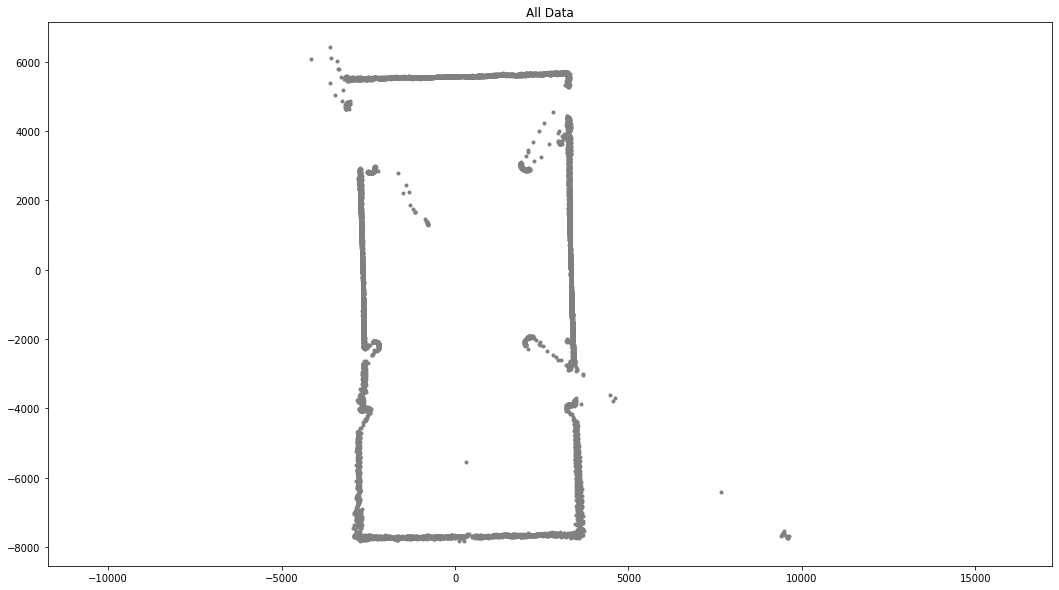

apply_max_range: 13779 points to 13765
mean_and_filter_angles: 13765 points to 2959
remove_lone_points: 2959 points to 2883


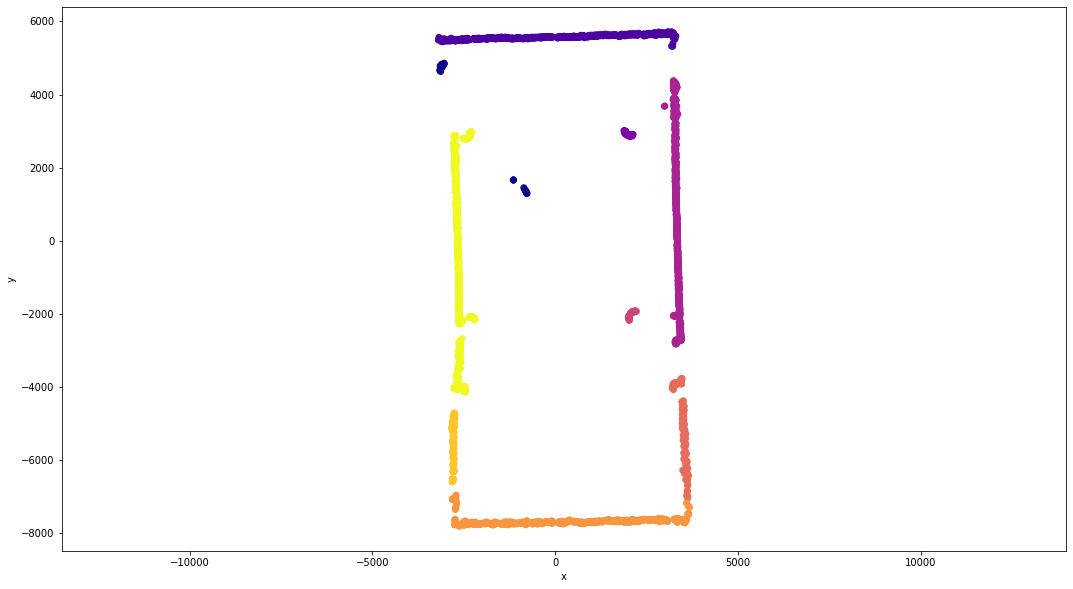

remove_small_clusters: 2883 points to 2858


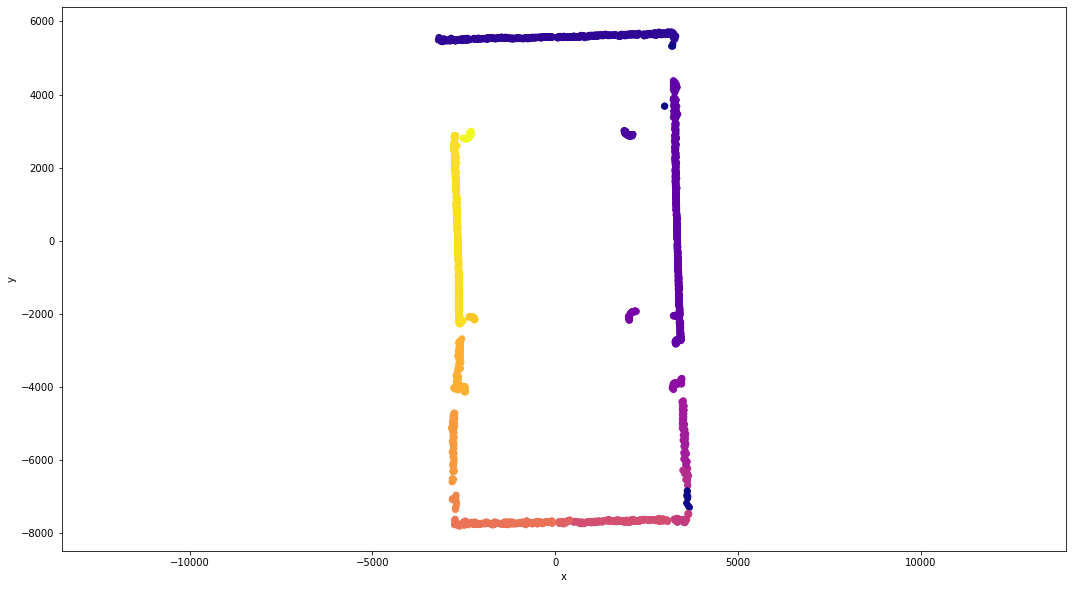

Mid: (16.587756, 5325.275867), Radius: 1617.409027, Heu: 782656.004067


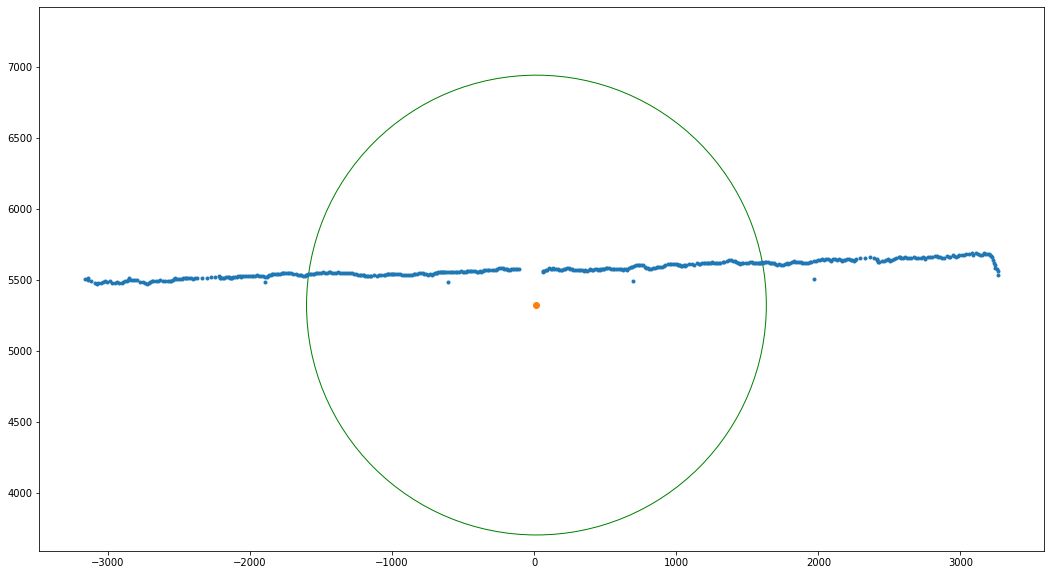

Mid: (1988.314268, 2938.765278), Radius: 68.171052, Heu: 439.939721


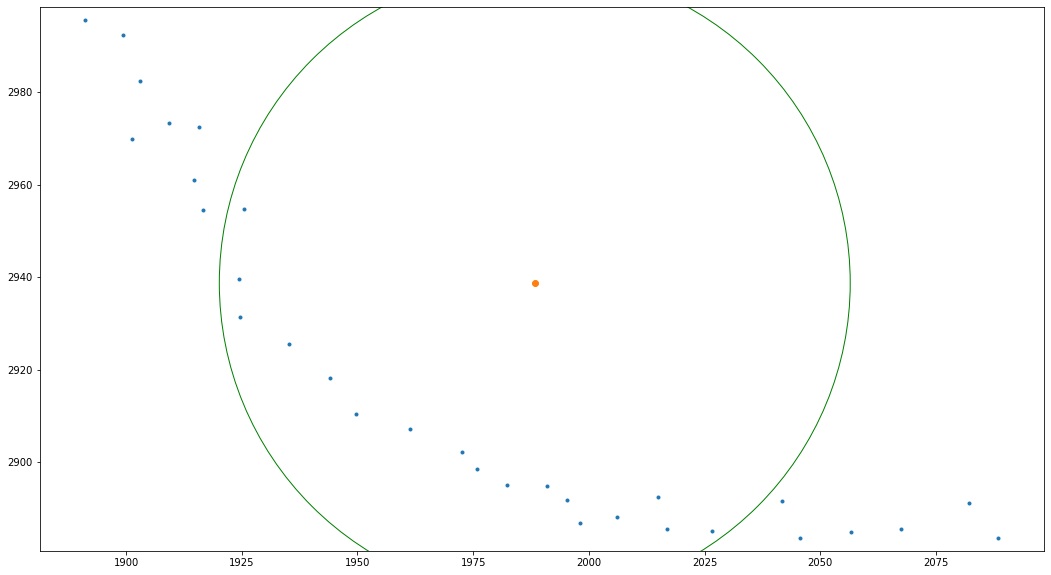

Mid: (3138.088701, 439.871097), Radius: 1559.309850, Heu: 957957.184370


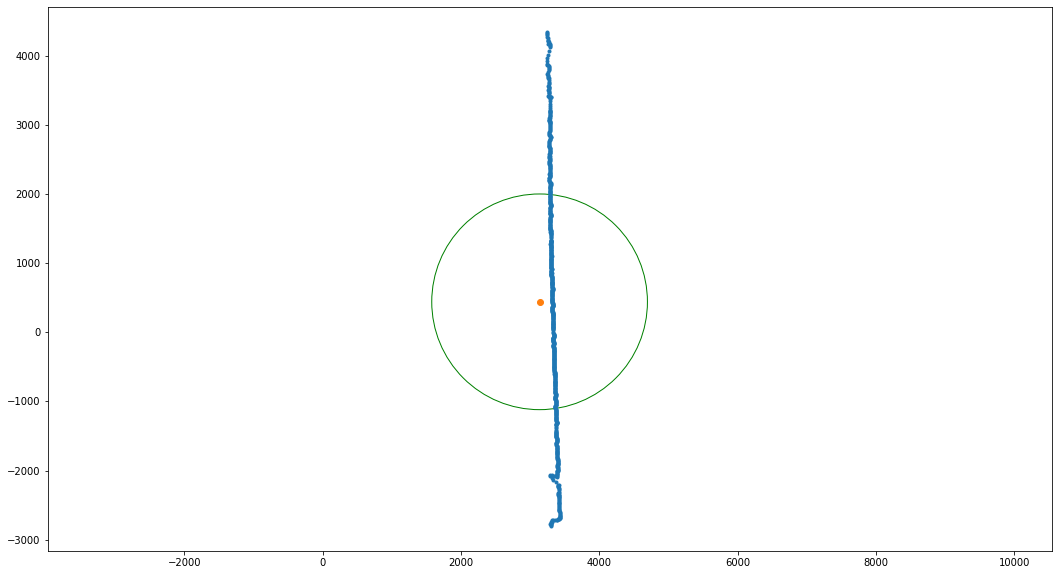

Mid: (2152.790119, -2072.095514), Radius: 136.542416, Heu: 53.271773


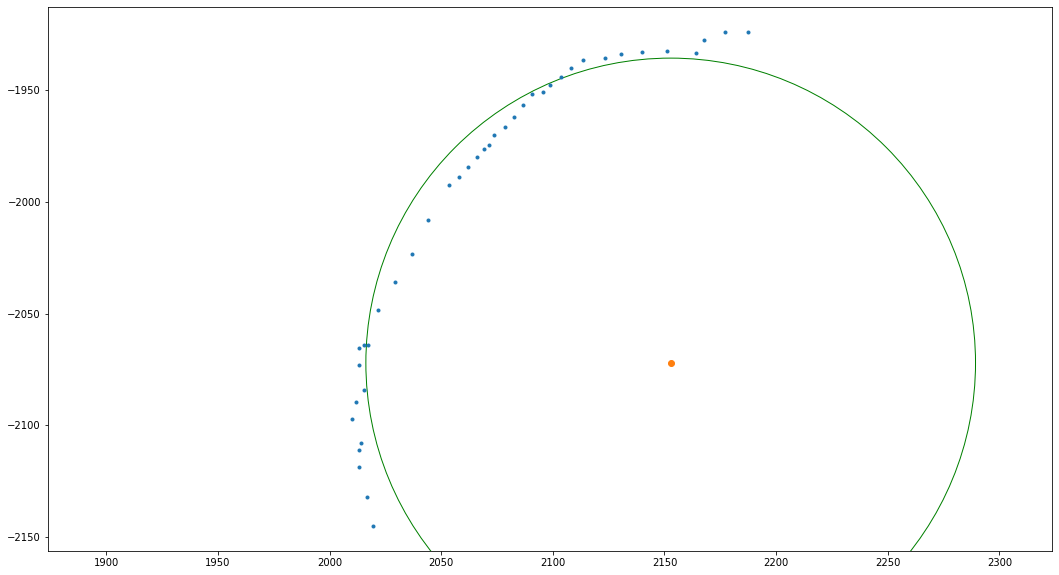

Mid: (3337.576261, -3905.126405), Radius: 84.960679, Heu: 1922.900481


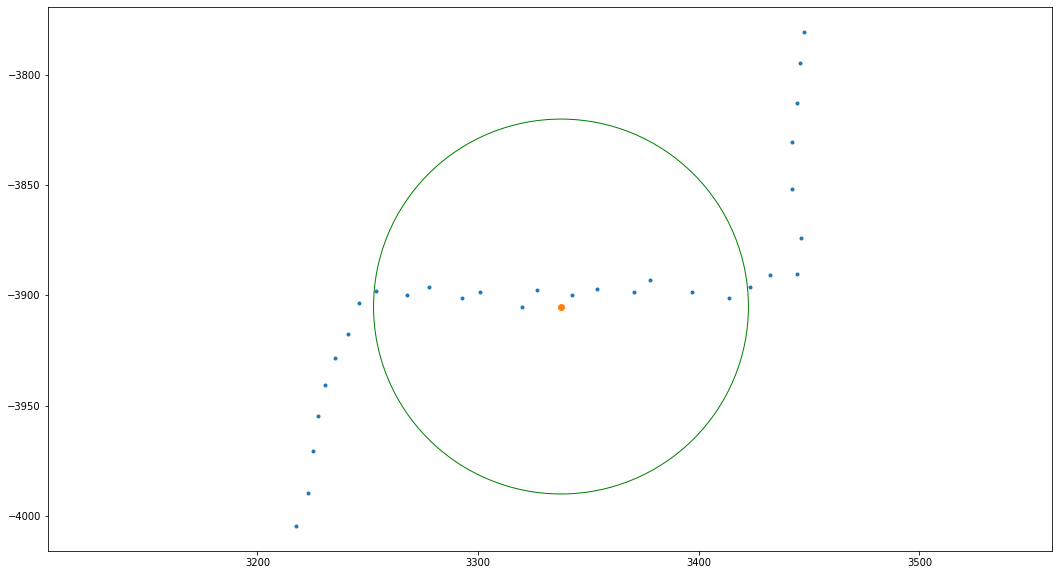

Mid: (3529.712701, -5152.089477), Radius: 417.850661, Heu: 56063.399373


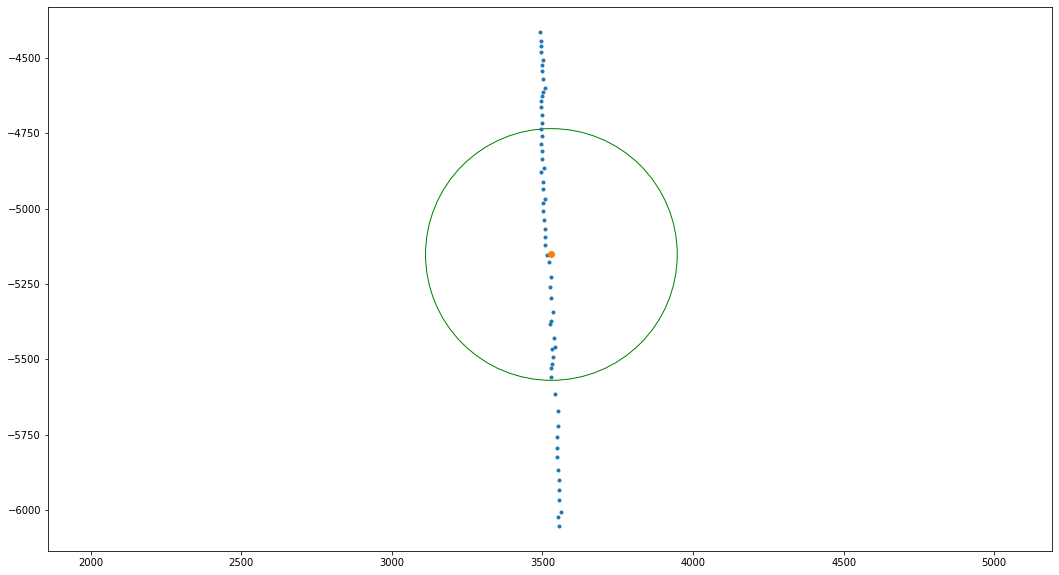

Mid: (3583.559776, -6440.965050), Radius: 57.623294, Heu: 905.163136


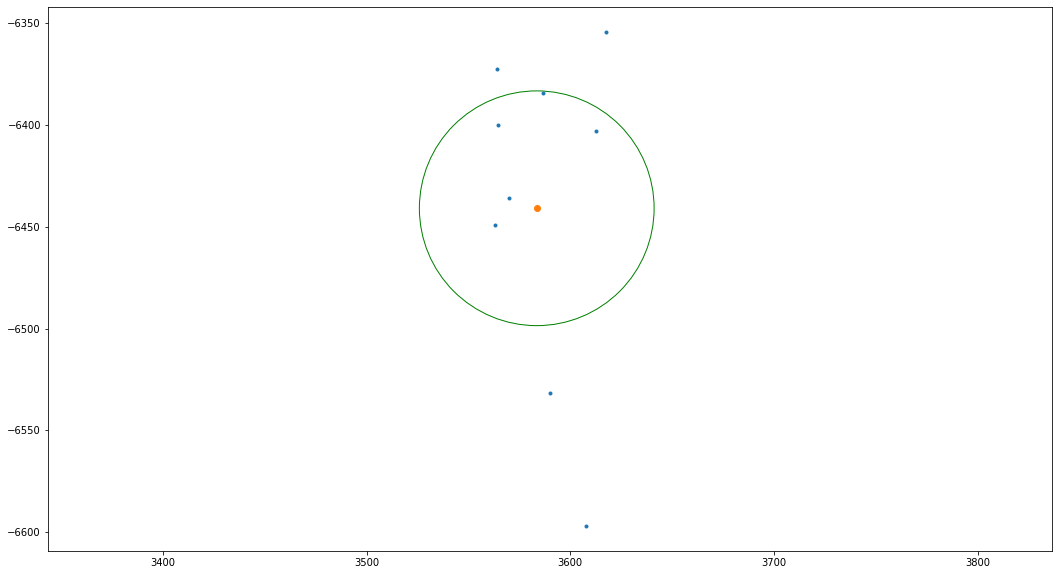

Mid: (3423.895936, -7571.646722), Radius: 123.990717, Heu: 1772.294890


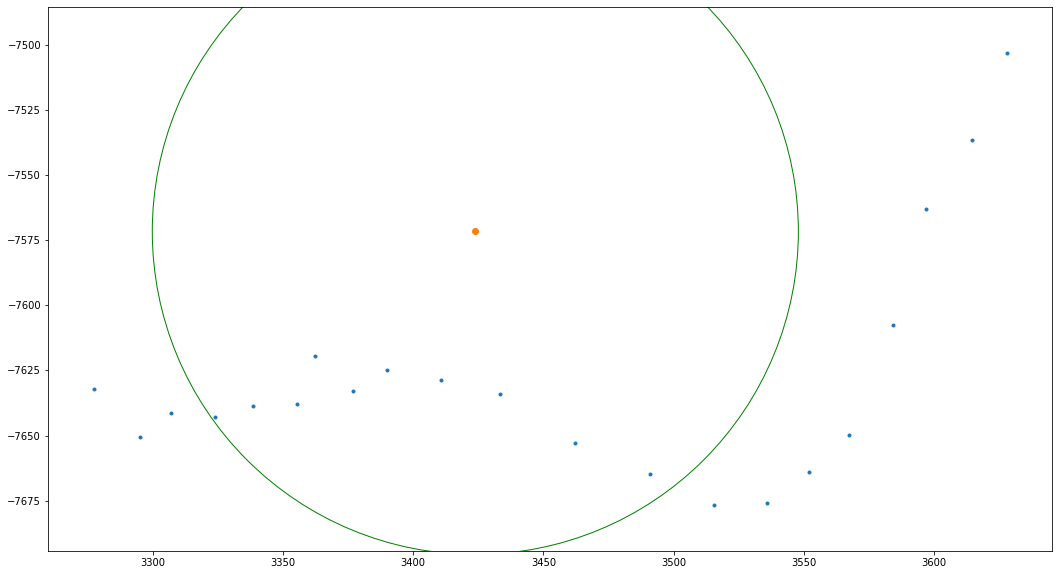

Mid: (1808.057543, -7713.307391), Radius: 619.834574, Heu: 124276.298951


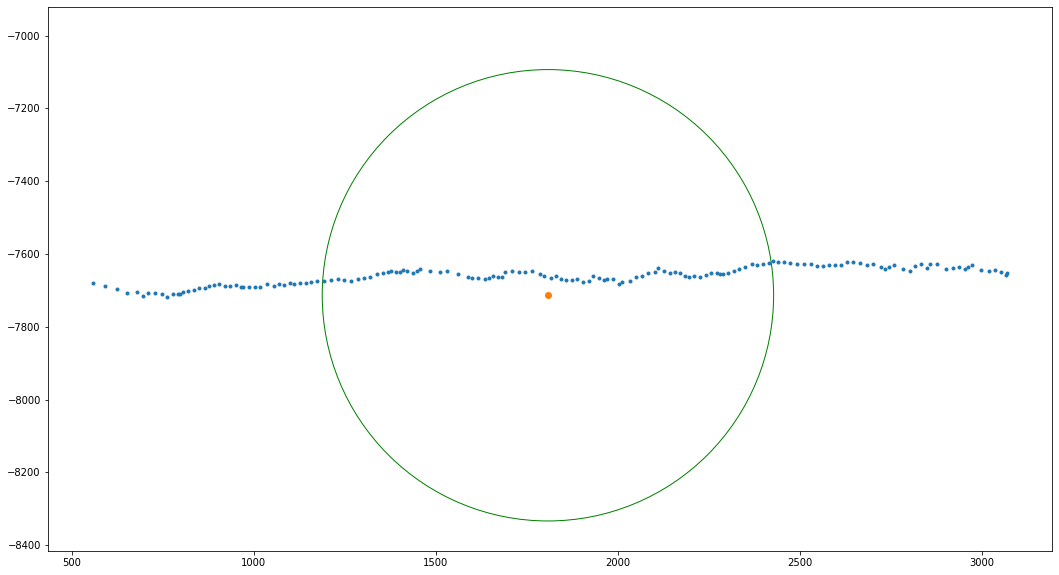

Mid: (215.373218, -7650.797369), Radius: 77.193851, Heu: 561.063003


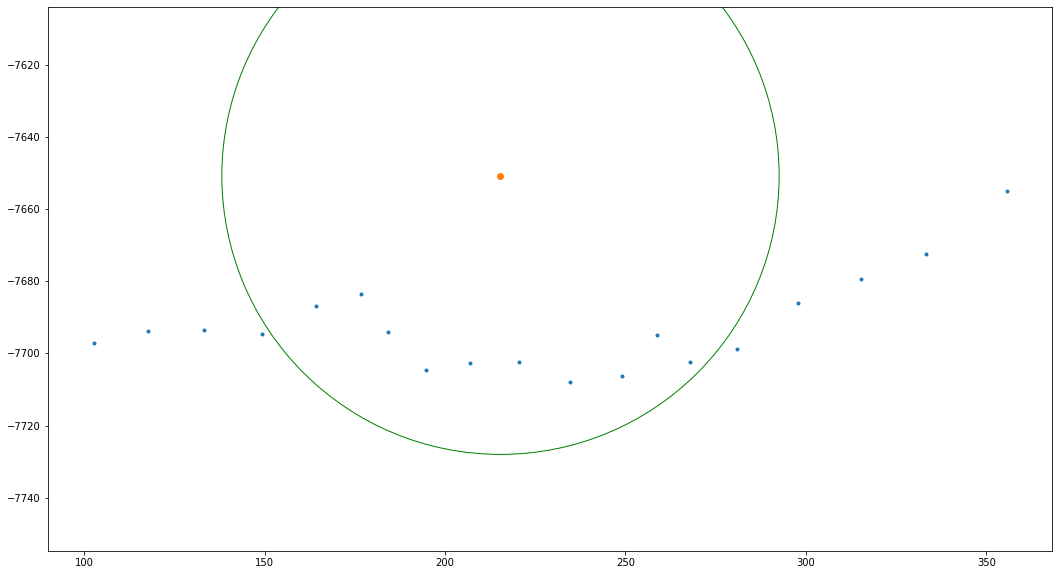

Mid: (-1336.598050, -7563.597918), Radius: 701.695405, Heu: 132518.949373


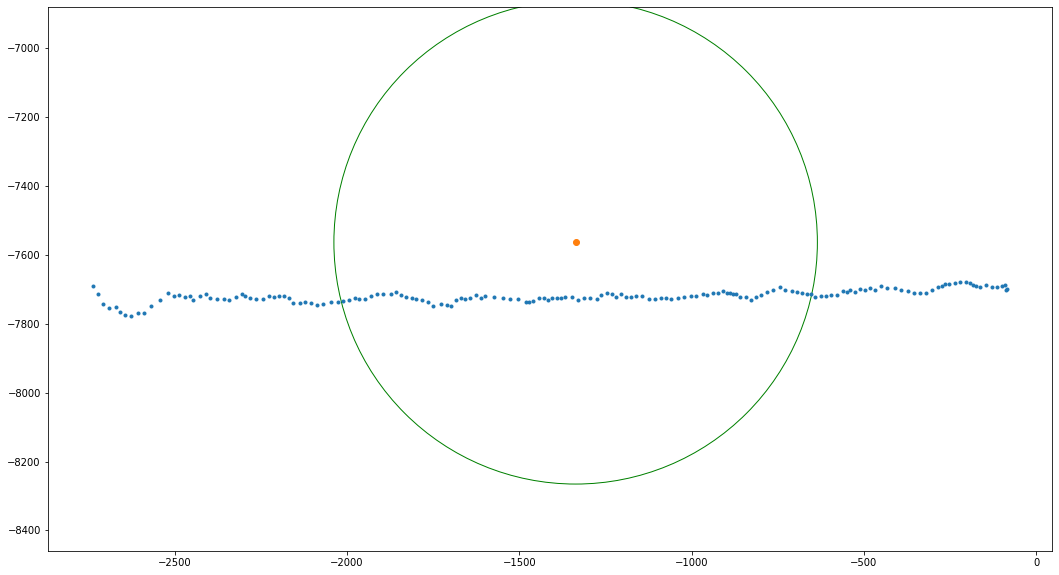

Mid: (-2748.184340, -7130.493816), Radius: 77.069053, Heu: 736.769166


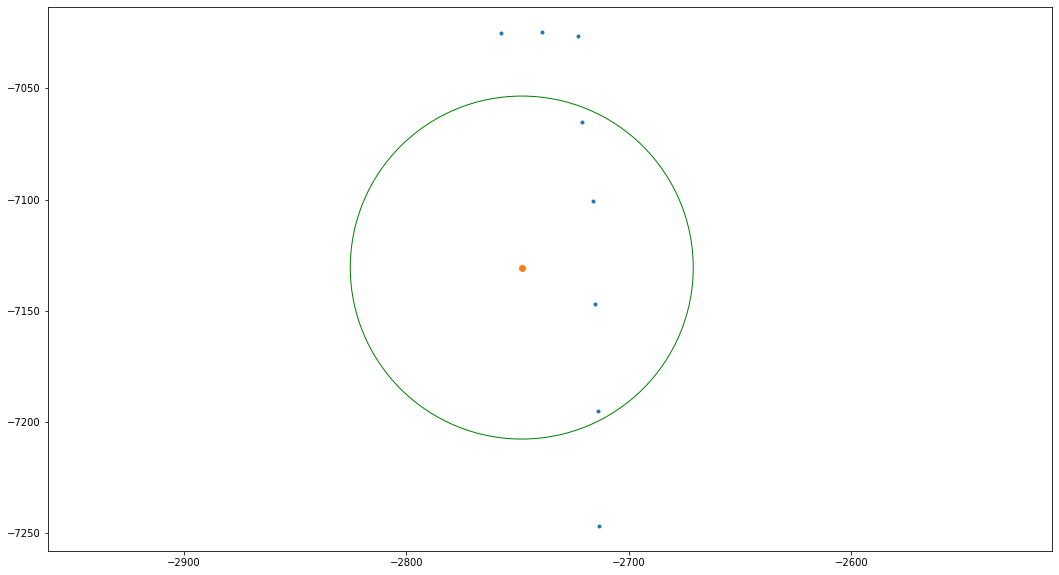

Mid: (-3048.223695, -5615.901705), Radius: 548.174299, Heu: 45903.092785


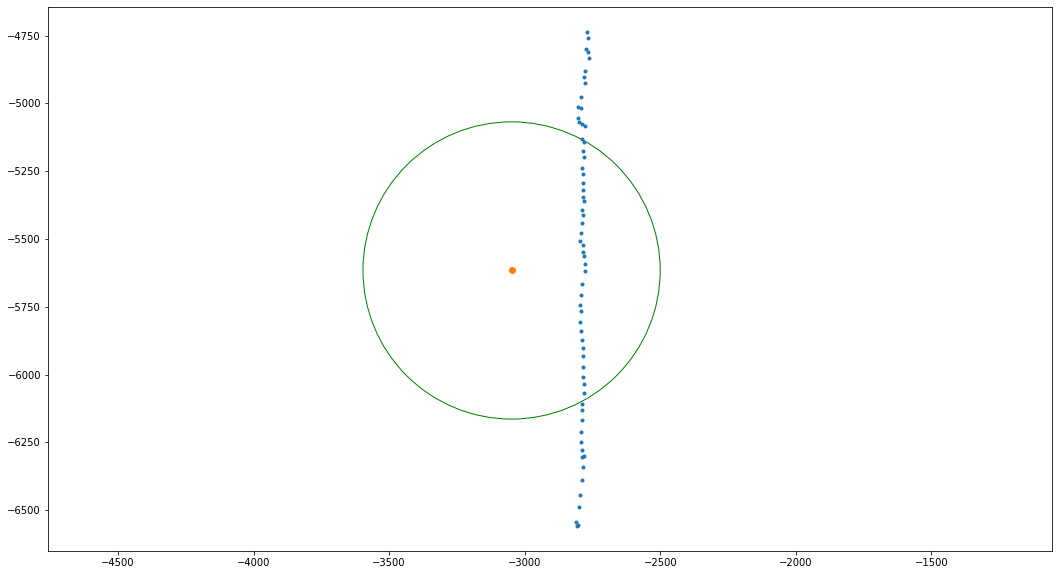

Mid: (-2681.582950, -3387.212960), Radius: 416.222701, Heu: 40993.431372


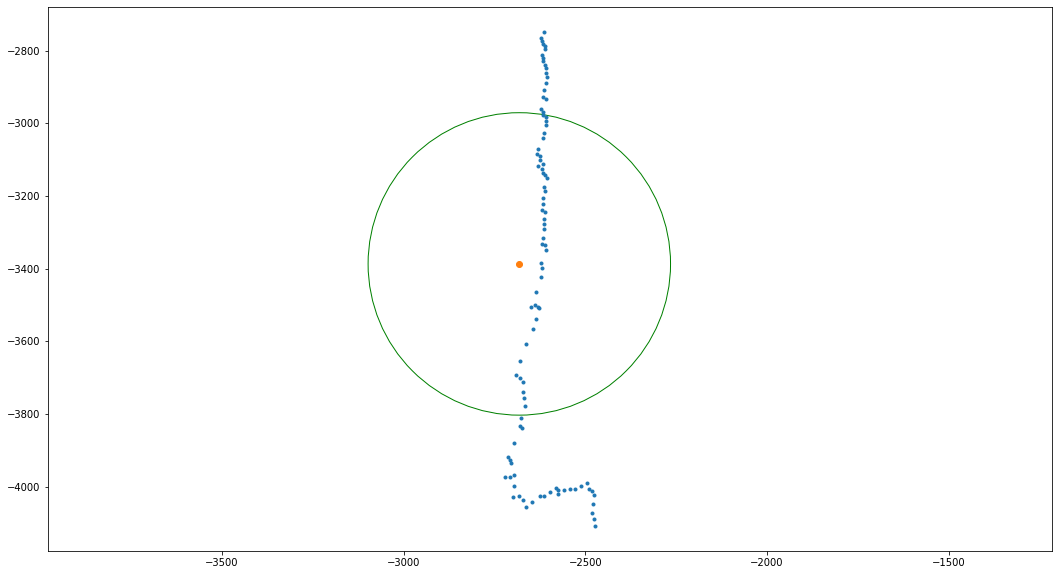

Mid: (-2290.688413, -2157.441409), Radius: 83.701018, Heu: 16.232614


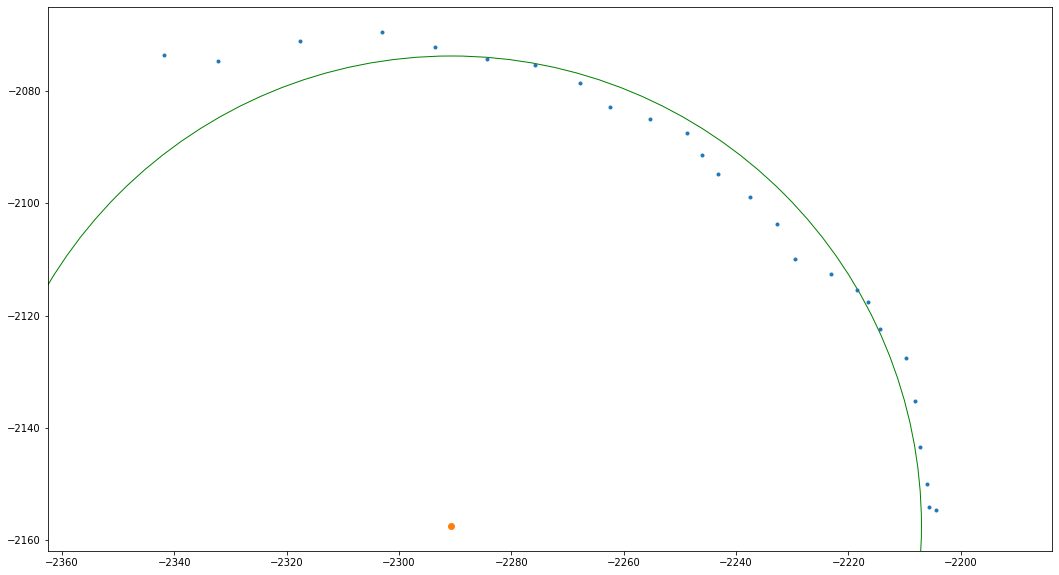

Mid: (-2560.259160, 159.528135), Radius: 1155.551206, Heu: 513494.274311


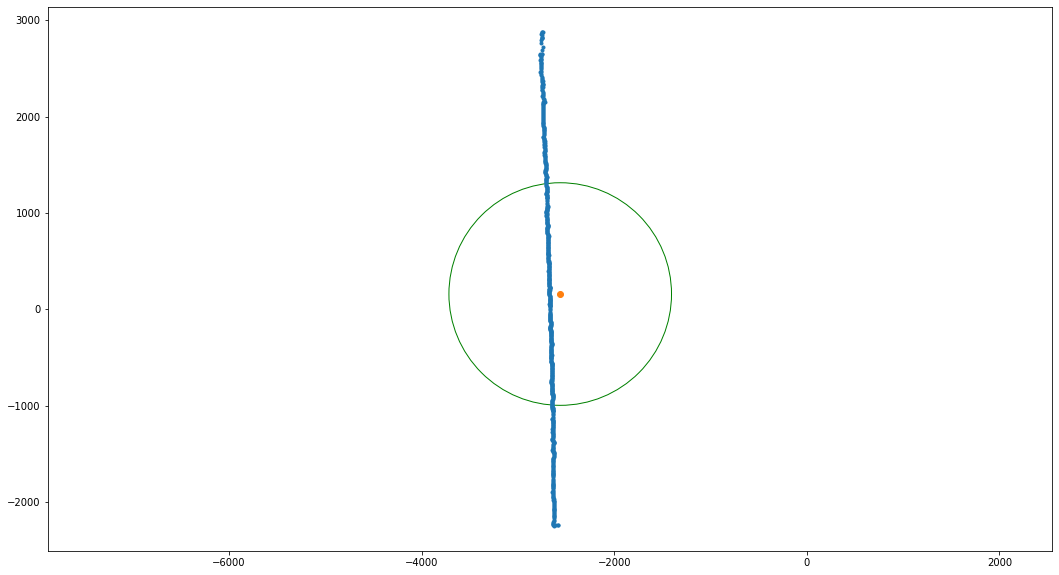

Mid: (-2432.463760, 2910.821304), Radius: 112.815913, Heu: 30.841742


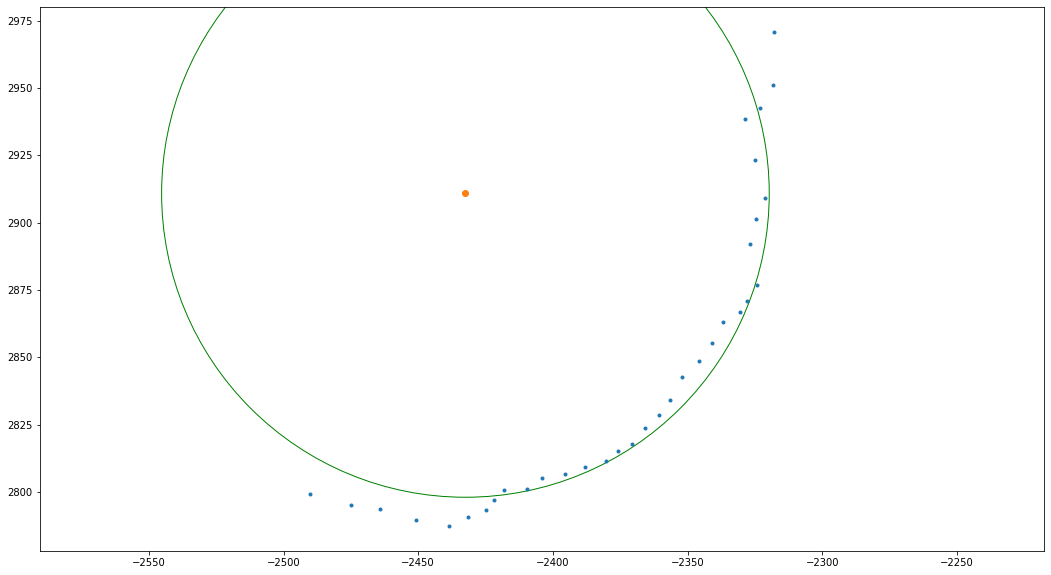

remove_pillars: 2858 points to 2734


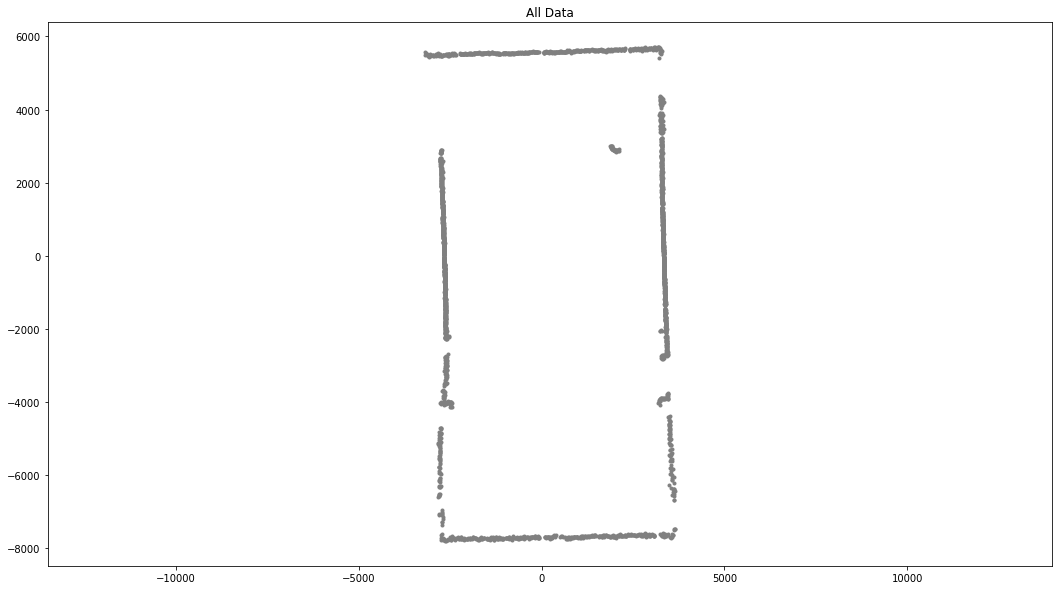

In [32]:
# read and clean data
ld1 = LidarData('scan-data-Room1-upto-50times.csv')
ld1.plot_xy()
ld1.apply_all_cleaning(verbose=True)
ld1.plot_xy()

In [33]:
# compute preliminary wall angles
angs = compute_ransac_angles(ld1.x, ld1.y, n_win=300, n_trials=100)

Total time: 31.772201s


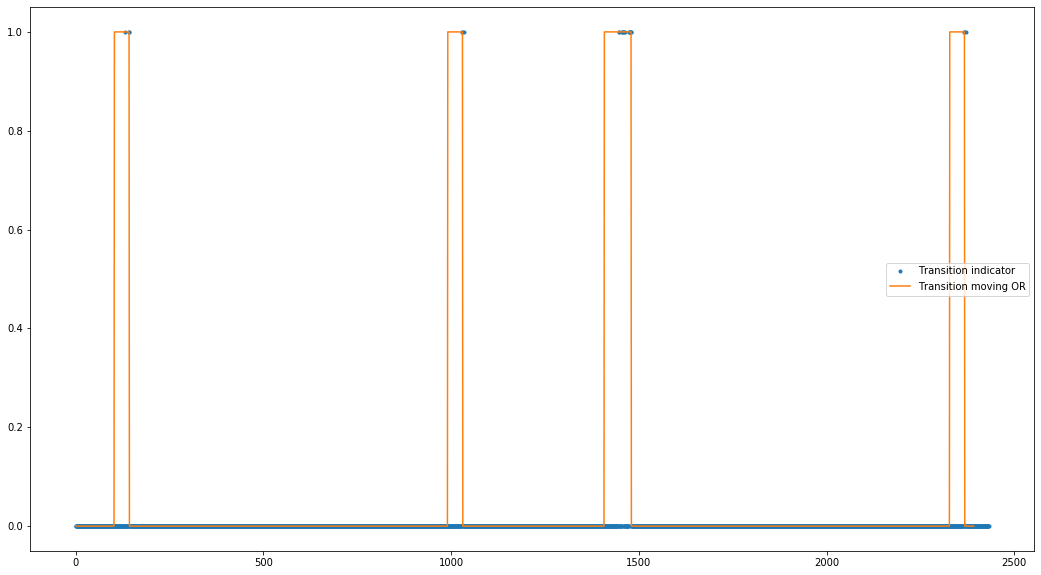

In [34]:
# search for wall transition regions (corners)
trans_slide = search_transition_regions(angs, verbose=True)

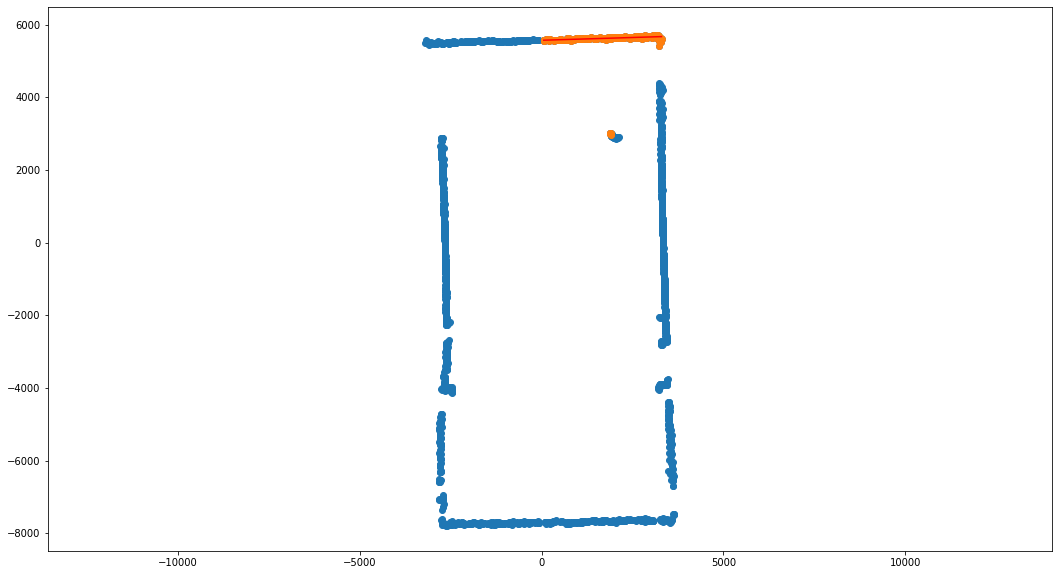

x_span: 3238.766642, y_span: 99.284199


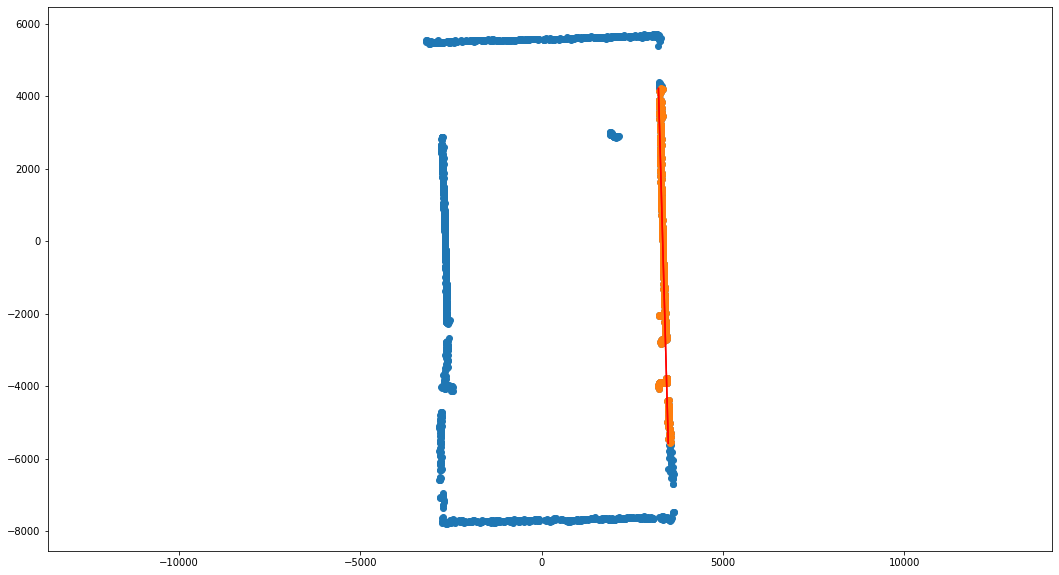

x_span: 271.529989, y_span: 9789.090290


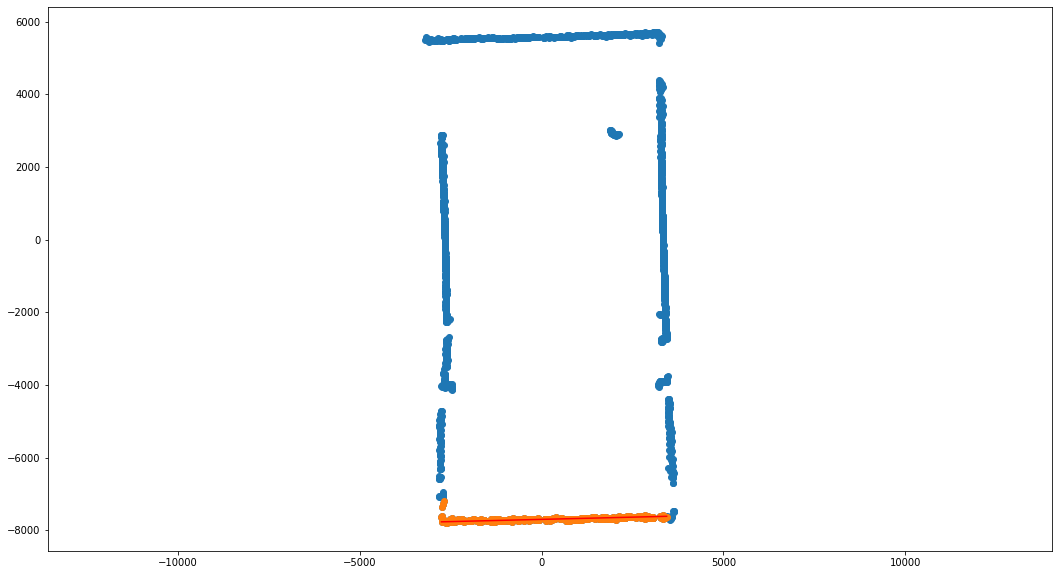

x_span: 6194.478601, y_span: 151.891845


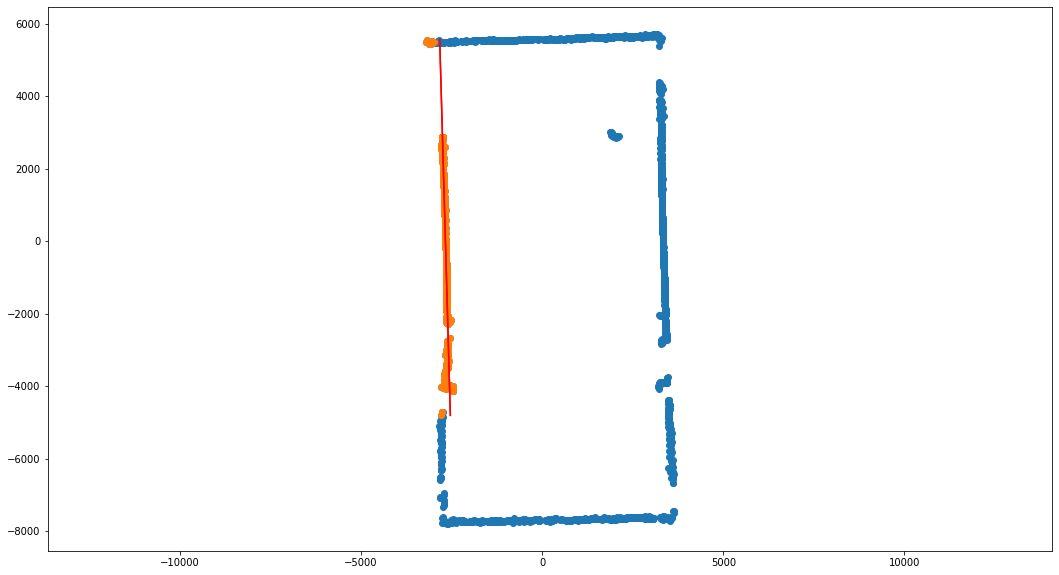

x_span: 293.553558, y_span: 10369.366026


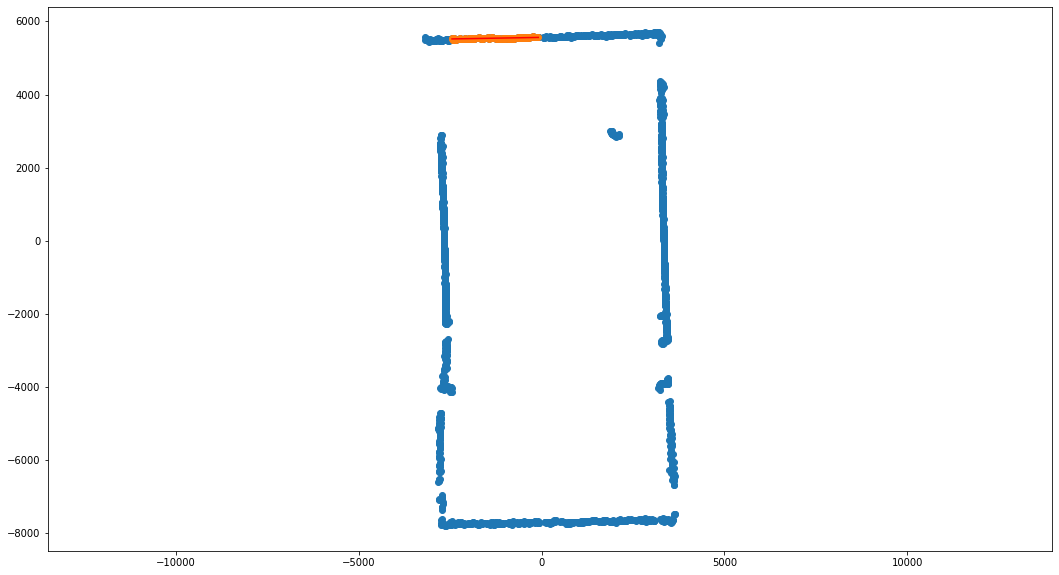

x_span: 2358.625905, y_span: 40.672848


In [35]:
# compute more robust wall estimations in stable regions
wall_lines = compile_walls(trans_slide, ld1.x, ld1.y, verbose=True)

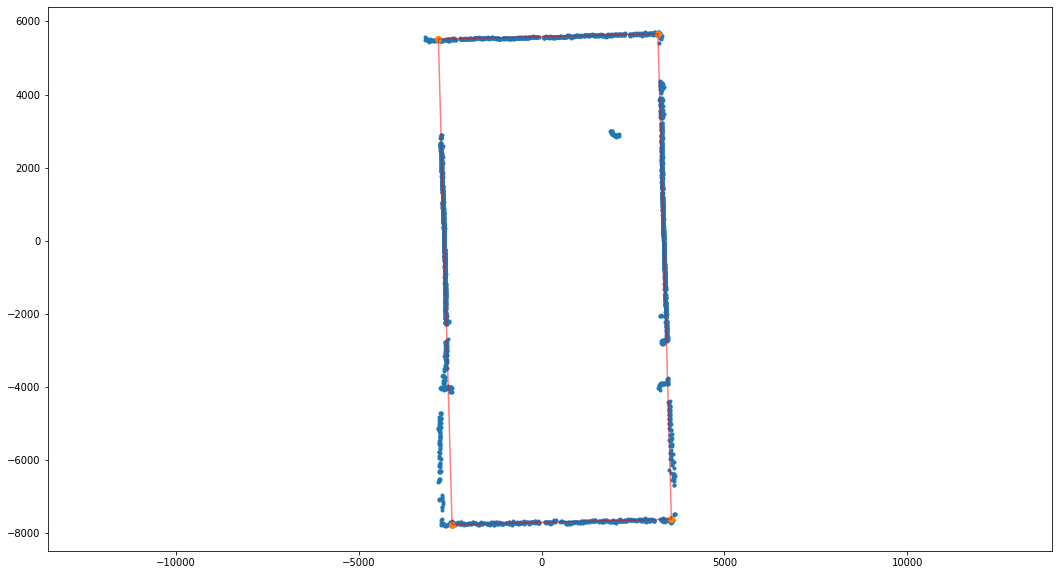

In [36]:
# find corners from robust walls
sects = get_wall_corners(wall_lines)
plot_corners(sects, ld1.x, ld1.y)

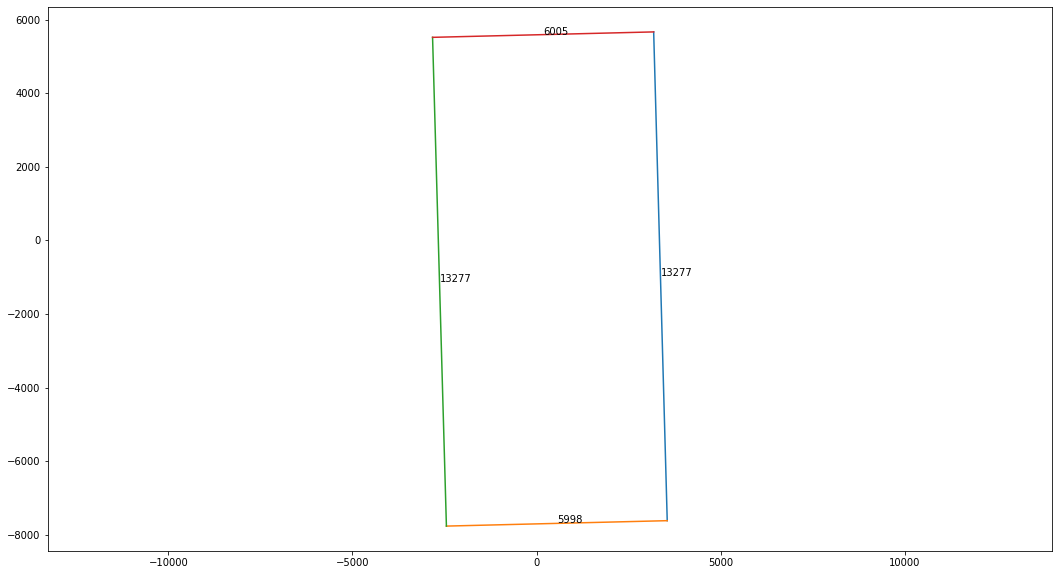

Wall length: 38559.557367


In [37]:
# get floor plan
lengths = compute_wall_lengths(sects, verbose=True)
print('Wall length: %f' % np.sum(lengths))

In [39]:
# total area
area = compute_polygon_area(sects[:,0], sects[:,1])
print('Floor area: %f' % area)

Floor area: 79693170.159330


Read 13431 points from scan-data-Room2-upto-50times.csv


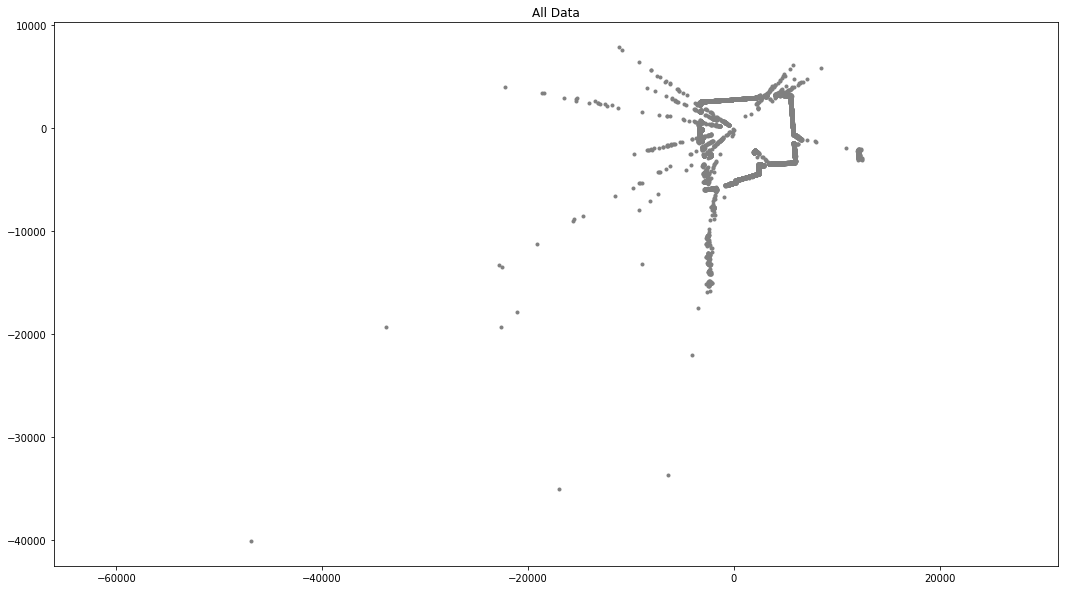

apply_max_range: 13431 points to 12990
mean_and_filter_angles: 12990 points to 1513
remove_lone_points: 1513 points to 1414


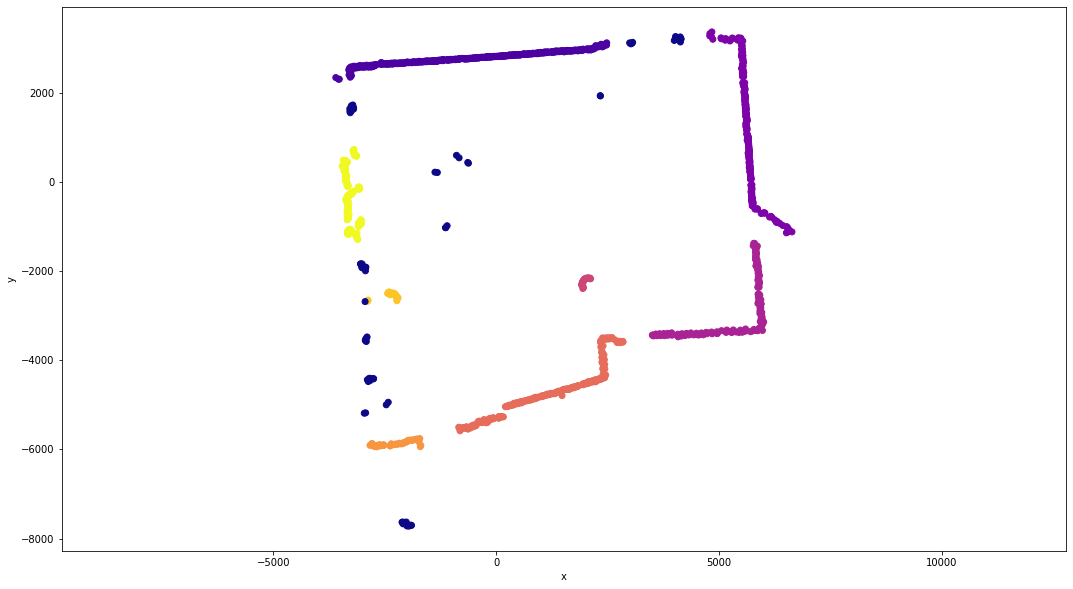

remove_small_clusters: 1414 points to 1334


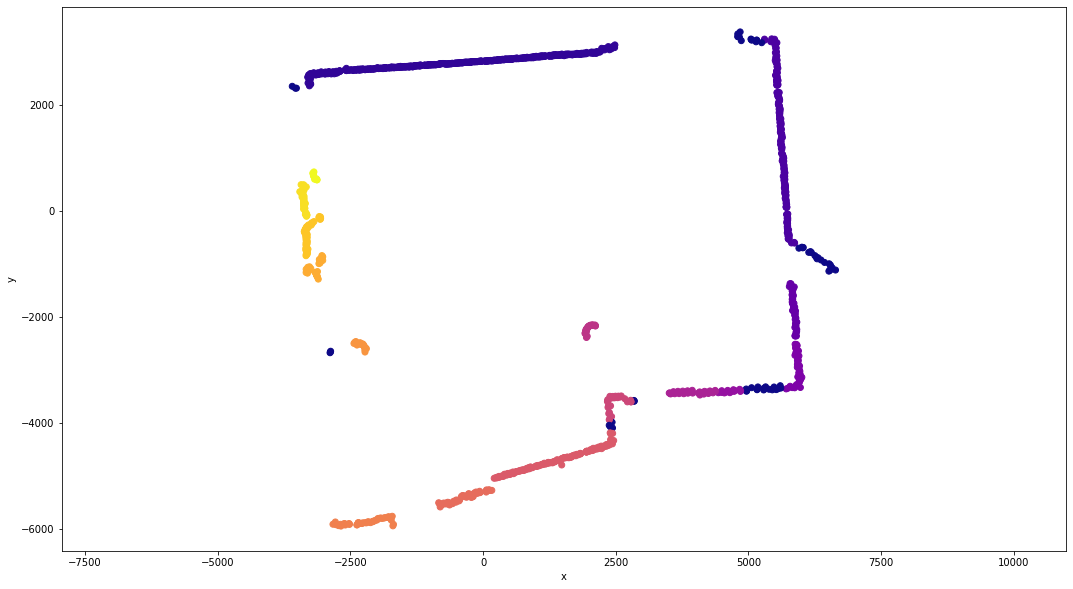

Mid: (-327.952180, 2206.947806), Radius: 1469.444665, Heu: 502595.178825


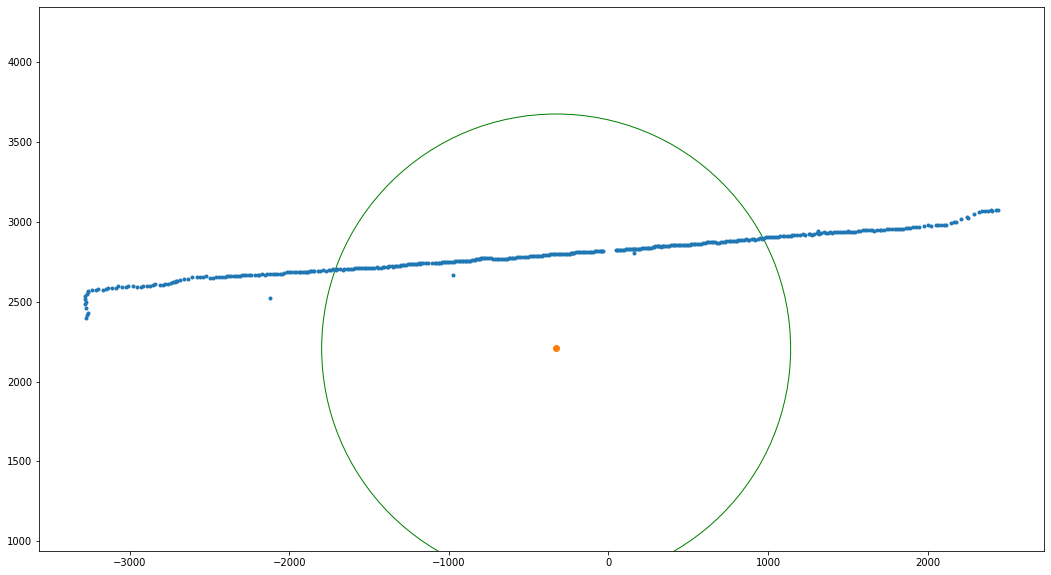

Mid: (5603.023969, 1226.925271), Radius: 933.892244, Heu: 307668.653613


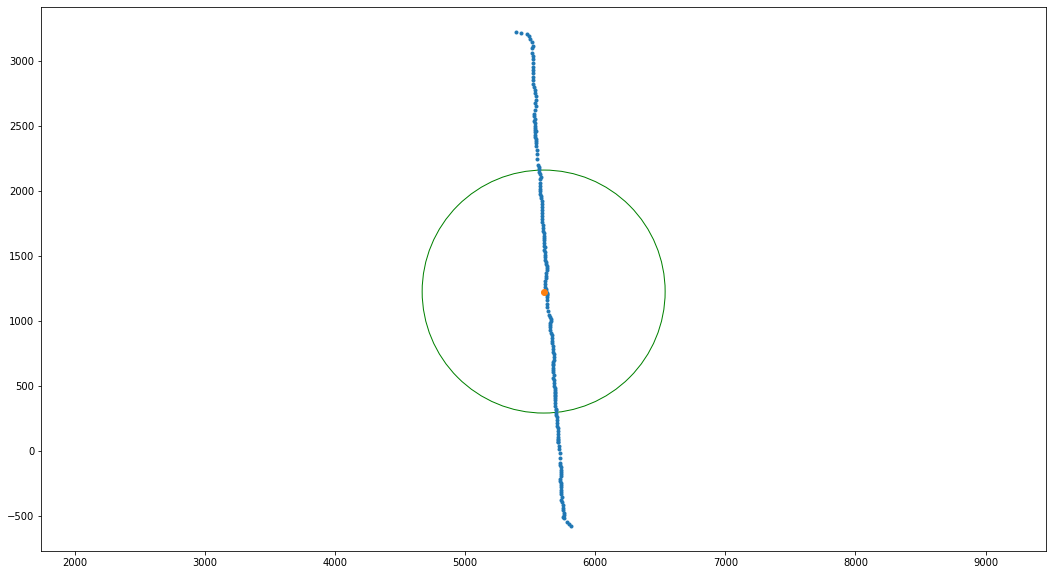

Mid: (5696.798443, -1873.067381), Radius: 304.859754, Heu: 12022.120801


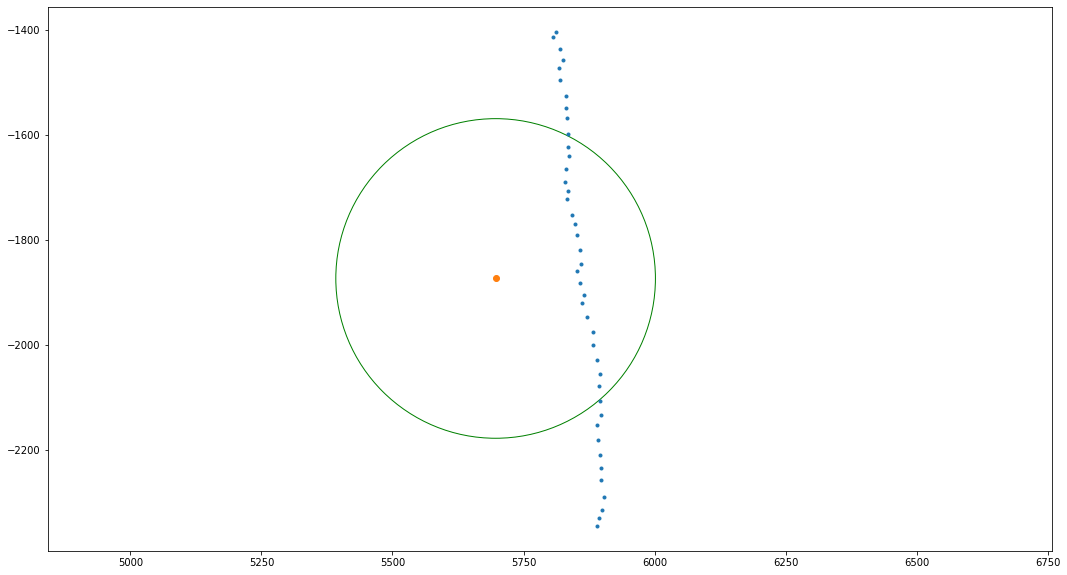

Mid: (5722.086046, -2916.793704), Radius: 325.396681, Heu: 5512.707502


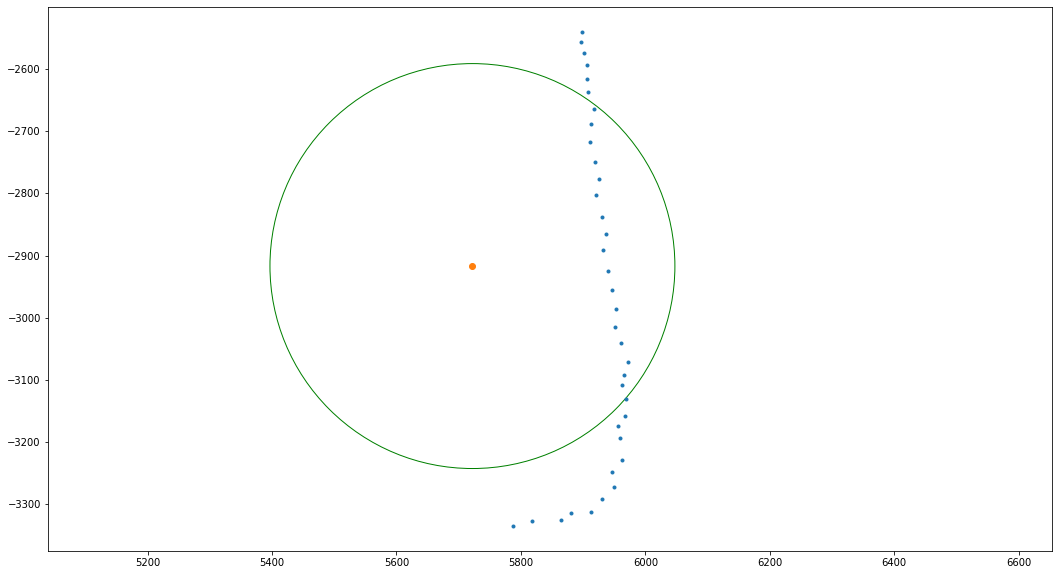

Mid: (4644.885615, -3329.401508), Radius: 107.617344, Heu: 801.759625


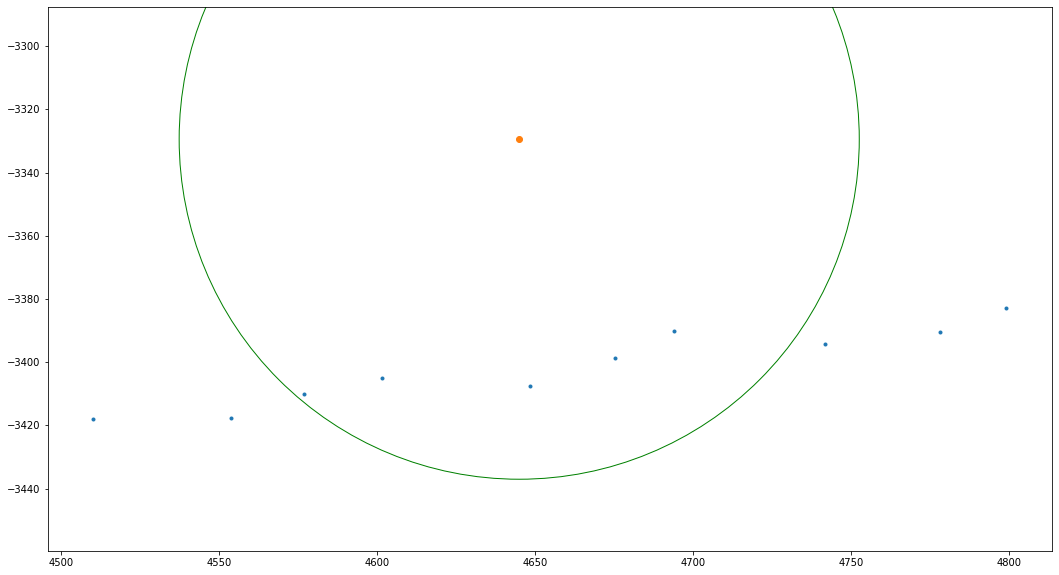

Mid: (3931.725305, -3436.049894), Radius: 215.049753, Heu: 12763.098973


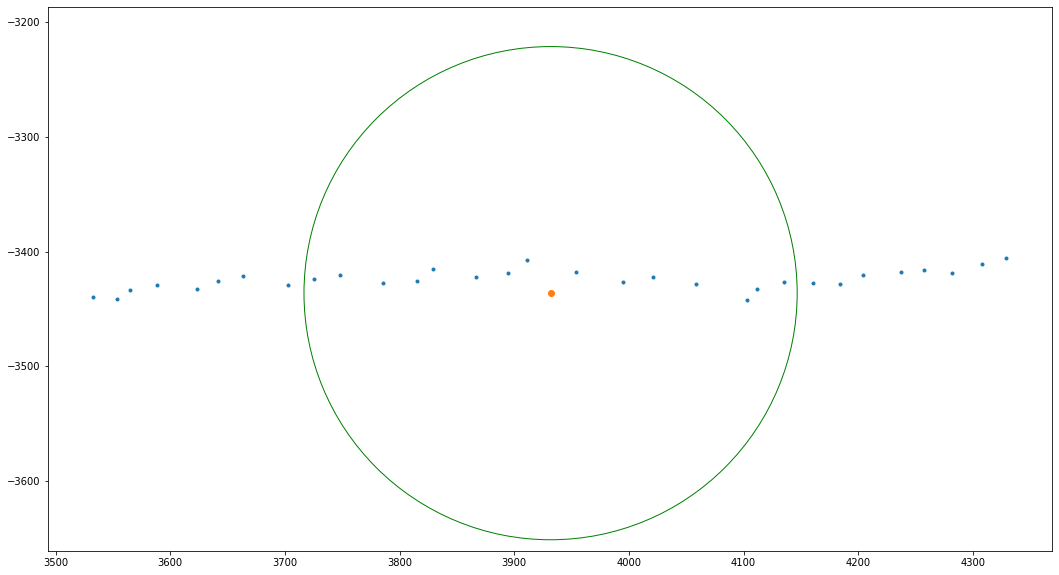

Mid: (2064.732799, -2285.816912), Radius: 128.992388, Heu: 3.803363


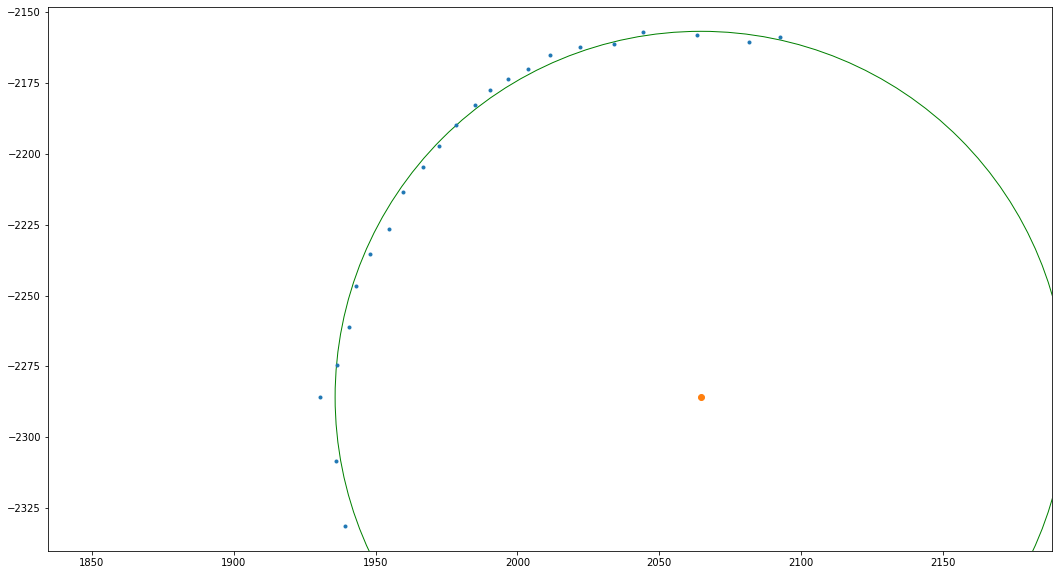

Mid: (2533.885755, -3709.114151), Radius: 203.198127, Heu: 347.128596


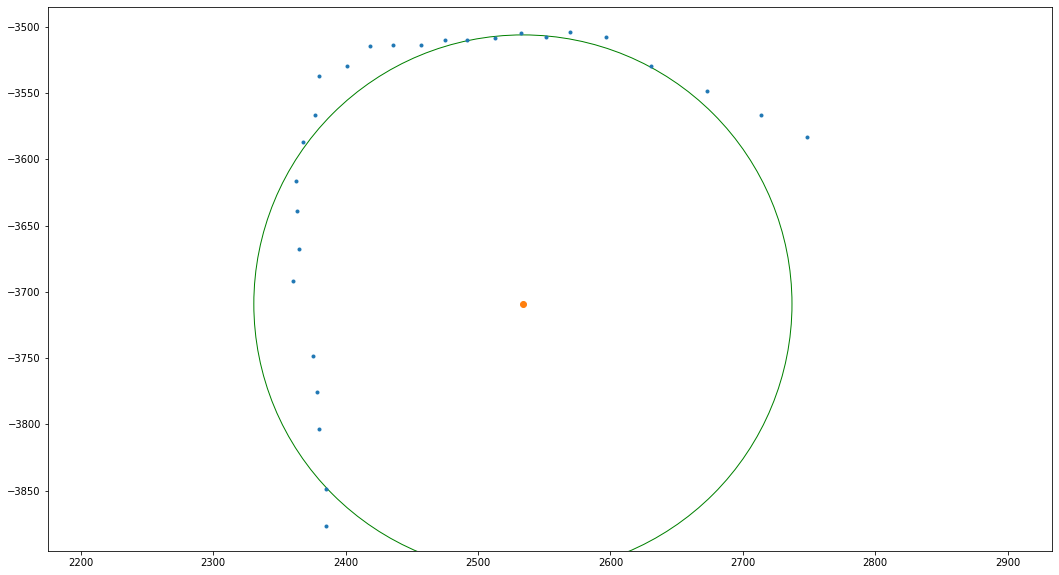

Mid: (1213.074091, -4299.399971), Radius: 756.164713, Heu: 61662.114244


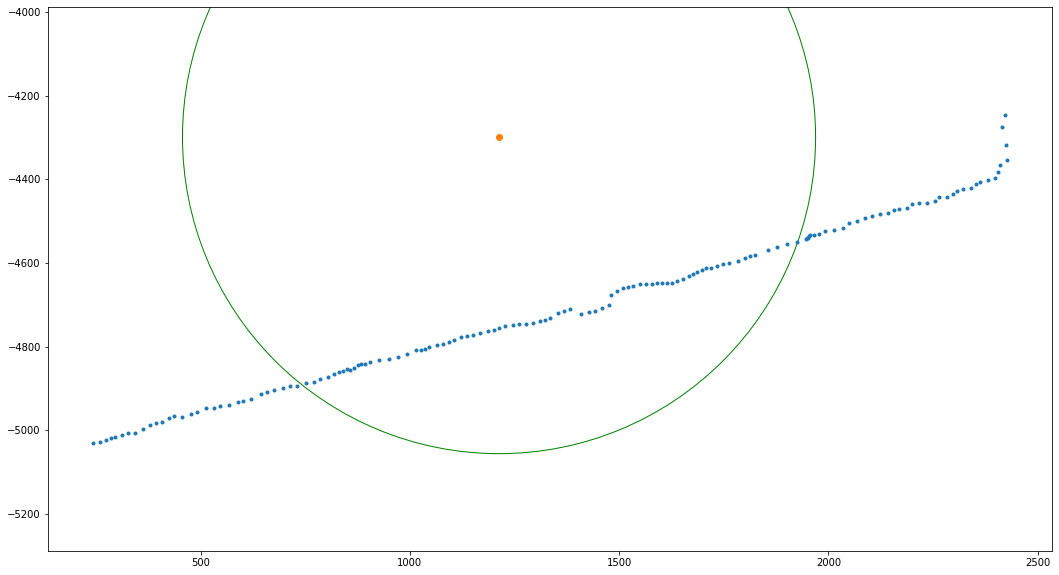

Mid: (-376.375463, -5349.031331), Radius: 274.711426, Heu: 19807.395339


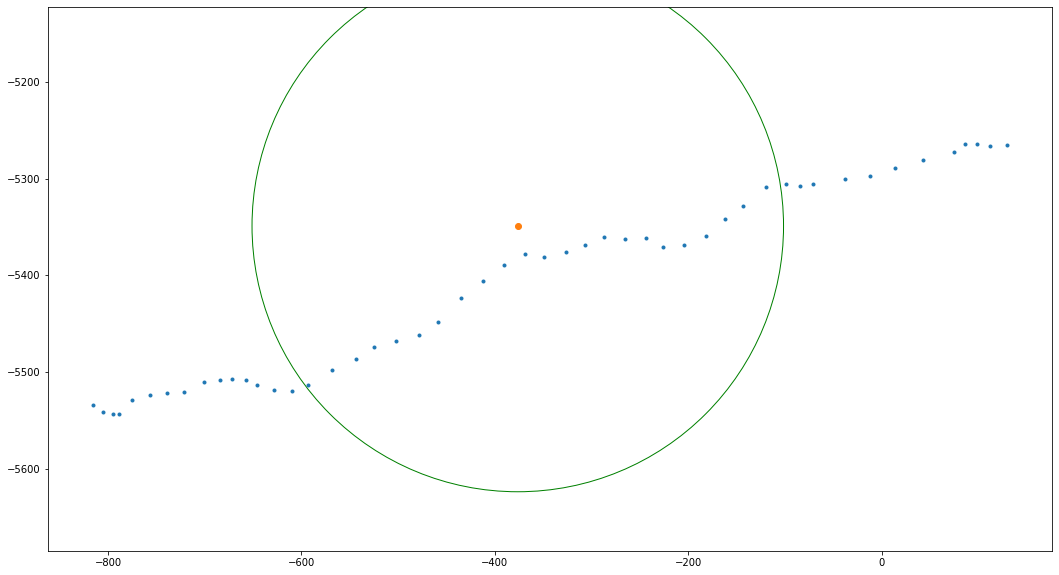

Mid: (-2260.011304, -5800.112370), Radius: 277.780151, Heu: 20281.658161


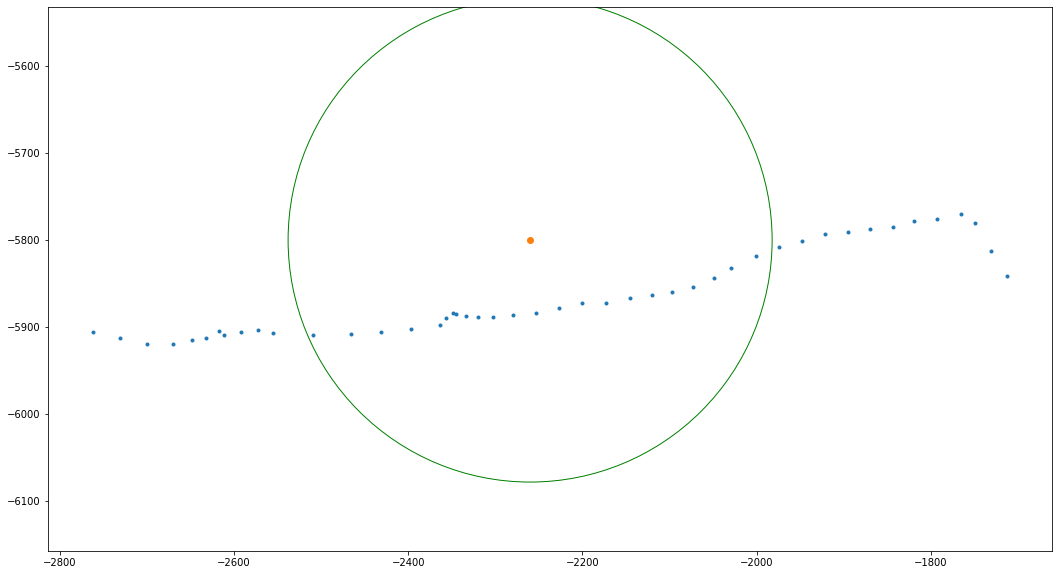

Mid: (-2355.449523, -2601.190790), Radius: 114.143352, Heu: 135.871544


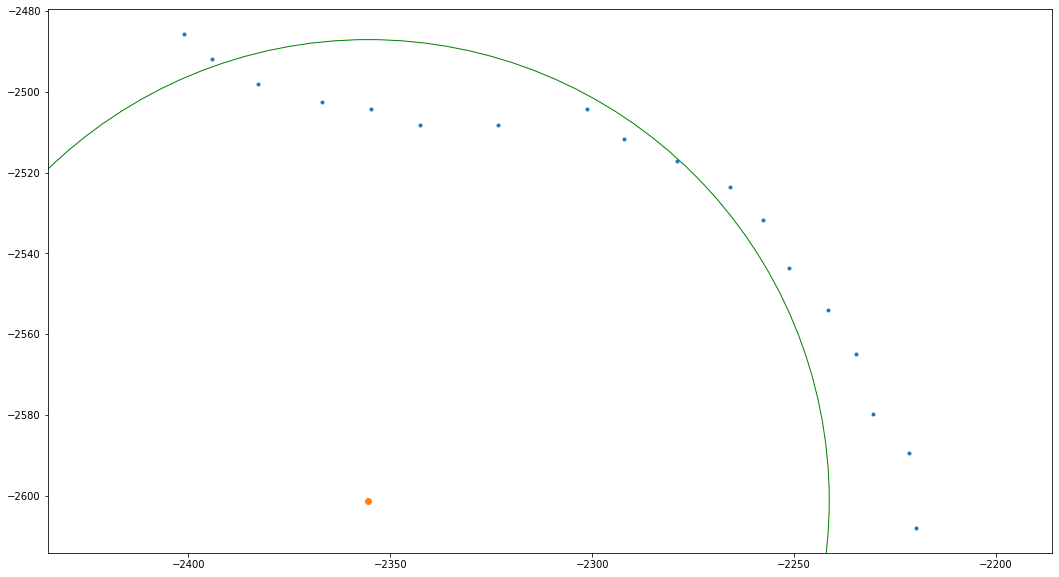

Mid: (-3127.754093, -1079.422970), Radius: 137.038460, Heu: 1283.125269


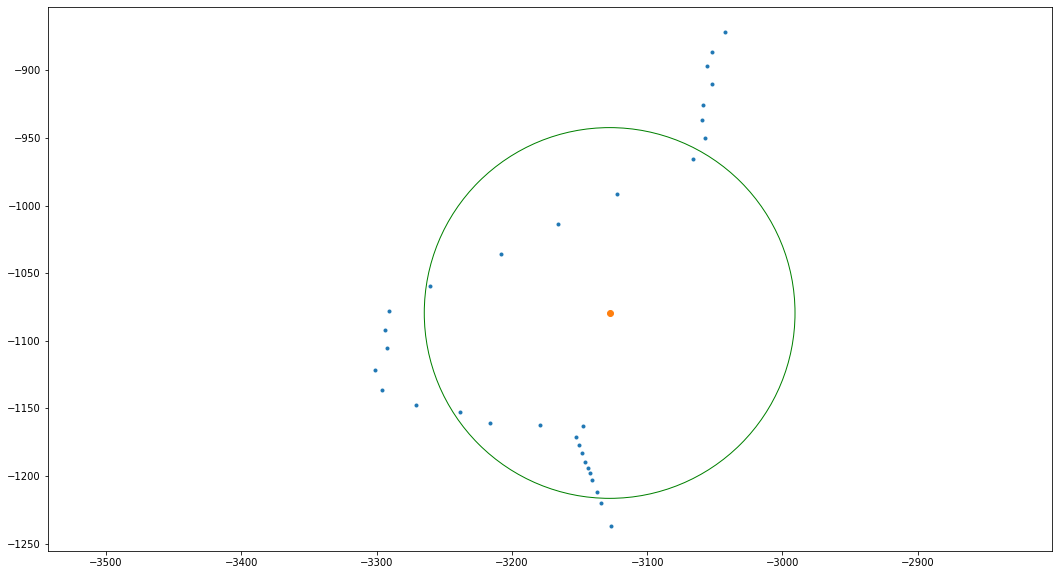

Mid: (-3088.690618, -526.241936), Radius: 297.402343, Heu: 1807.612597


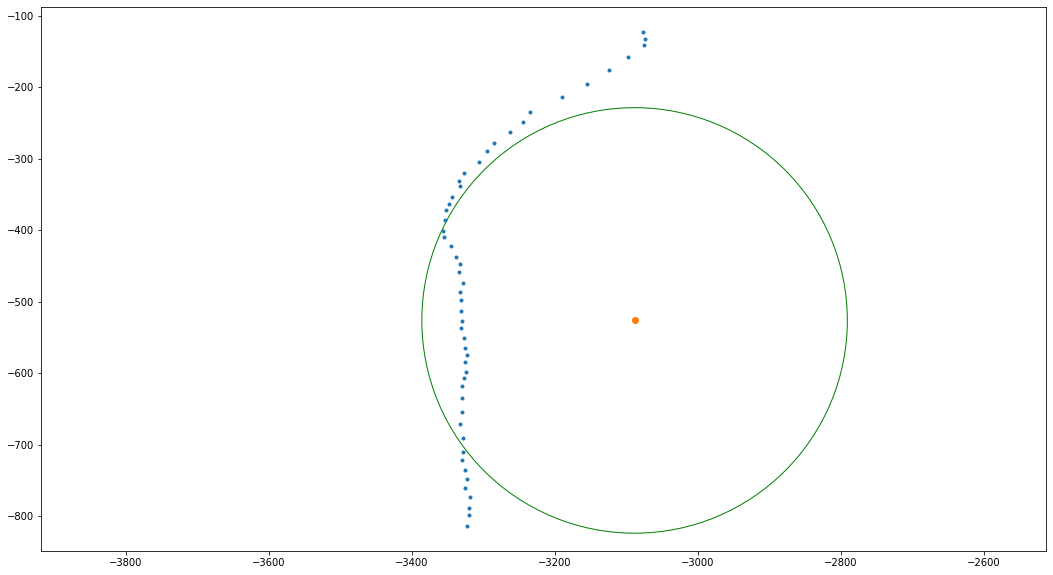

Mid: (-3266.136727, 202.283111), Radius: 183.993533, Heu: 2859.393553


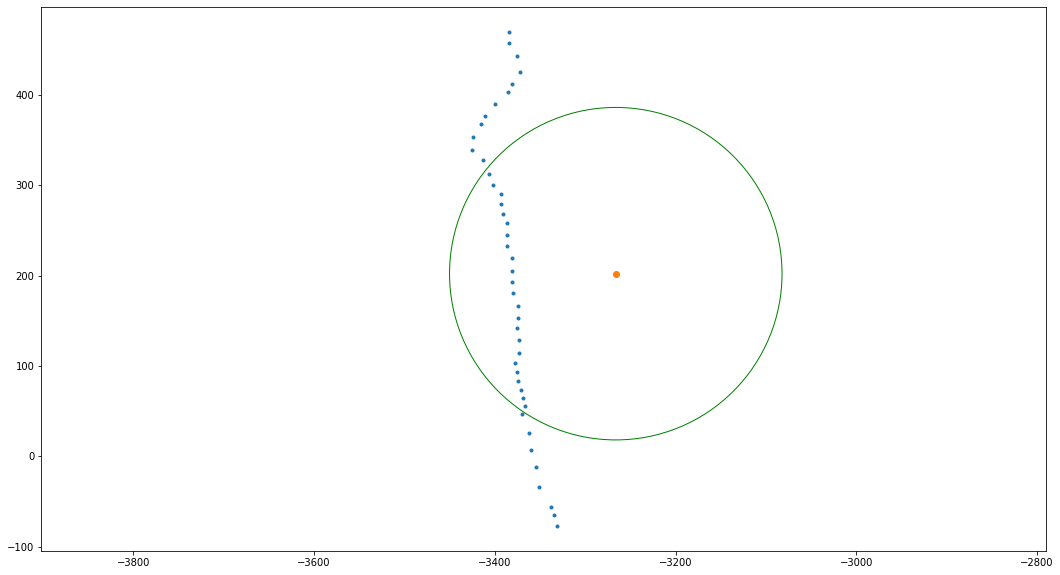

Mid: (-3092.690036, 682.713026), Radius: 100.278348, Heu: 26.265218


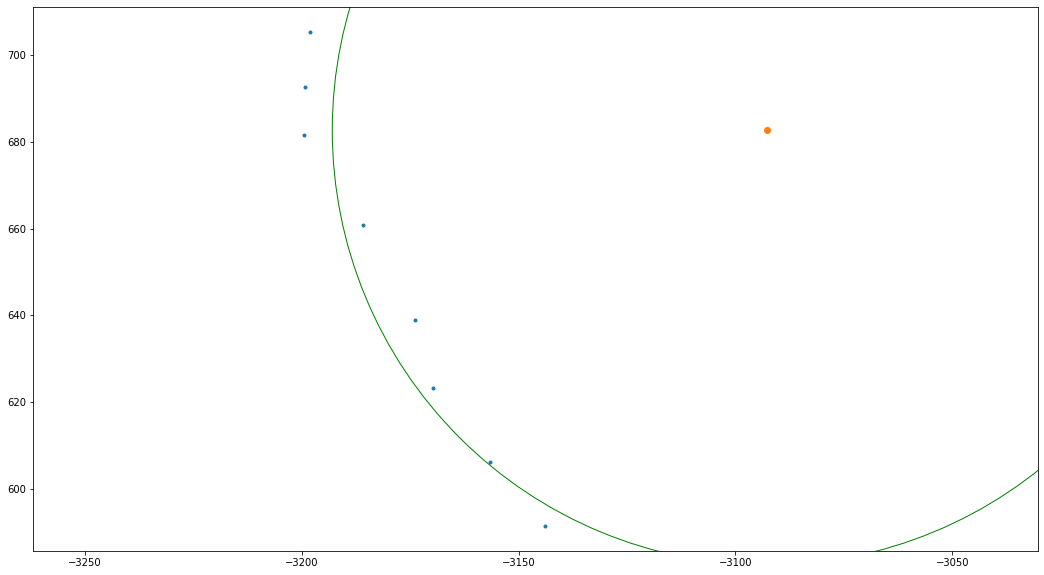

remove_pillars: 1334 points to 1209


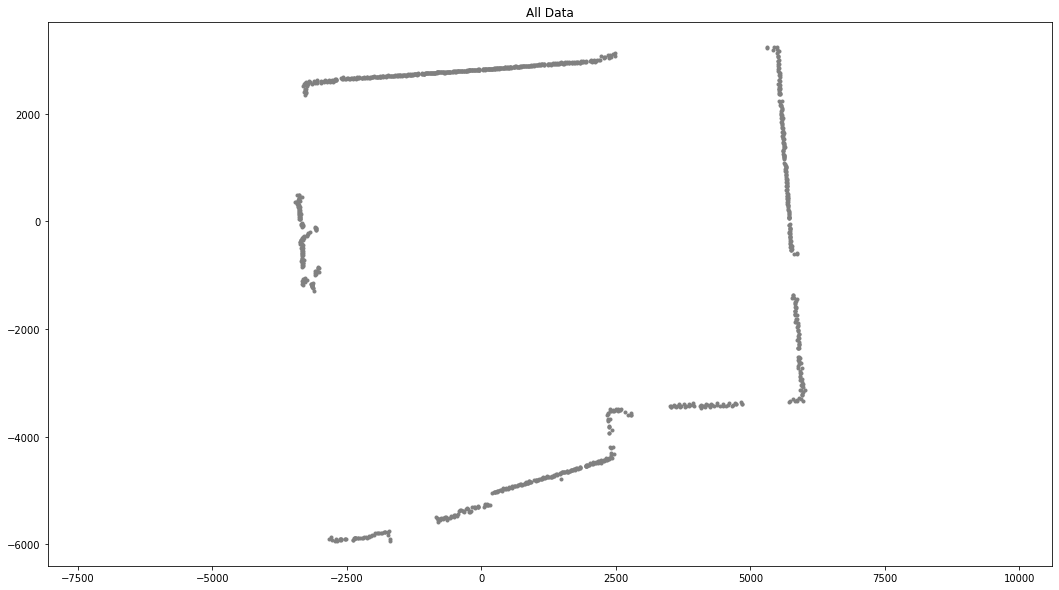

In [40]:
# read and clean data
ld2 = LidarData('scan-data-Room2-upto-50times.csv')
ld2.plot_xy()
ld2.apply_all_cleaning(verbose=True)
ld2.plot_xy()

In [41]:
# compute preliminary wall angles
angs = compute_ransac_angles(ld2.x, ld2.y, n_win=25, n_trials=50)

Total time: 7.103470s


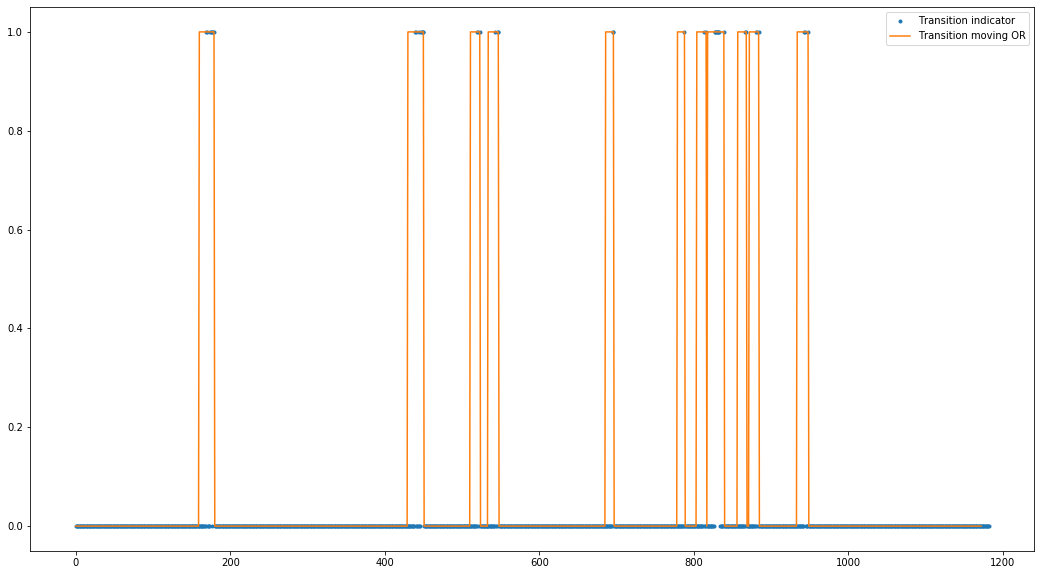

In [42]:
# search for wall transition regions (corners)
trans_slide = search_transition_regions(angs, slide_win=10, angle_threshold=0.3, count_thresh=0, verbose=True)

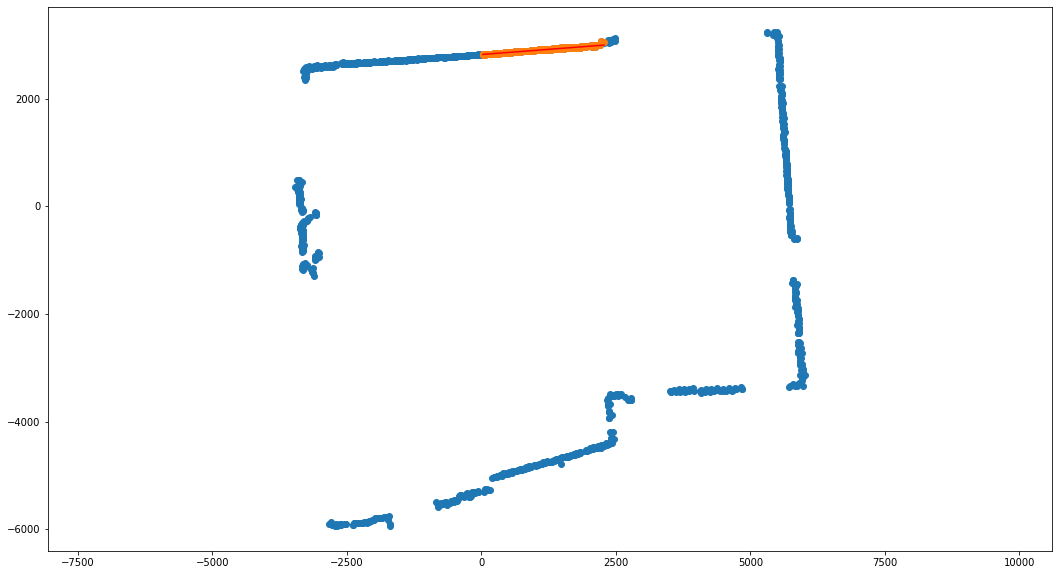

x_span: 2250.775934, y_span: 173.786012


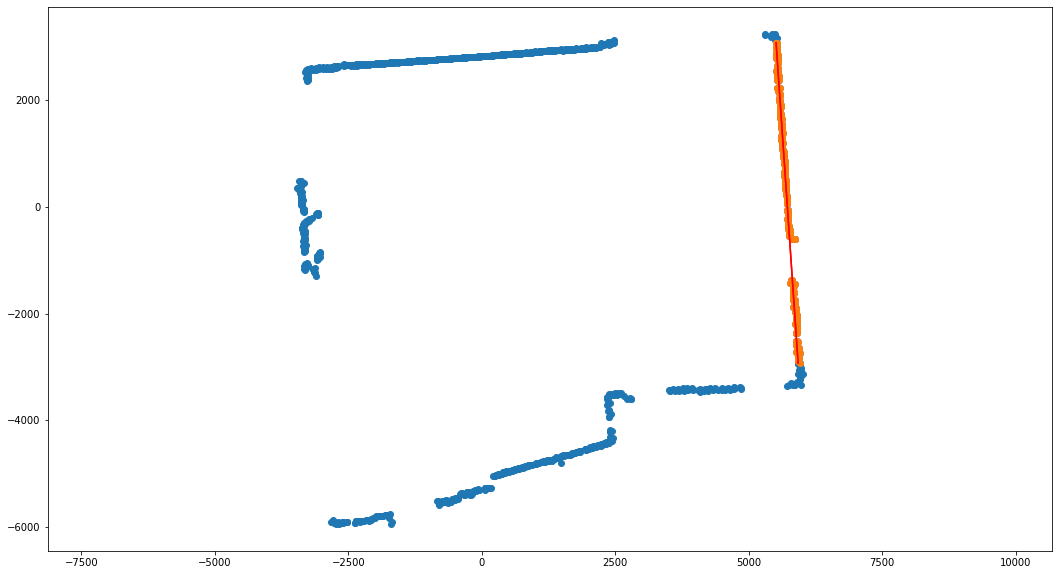

x_span: 411.980406, y_span: 5999.724903


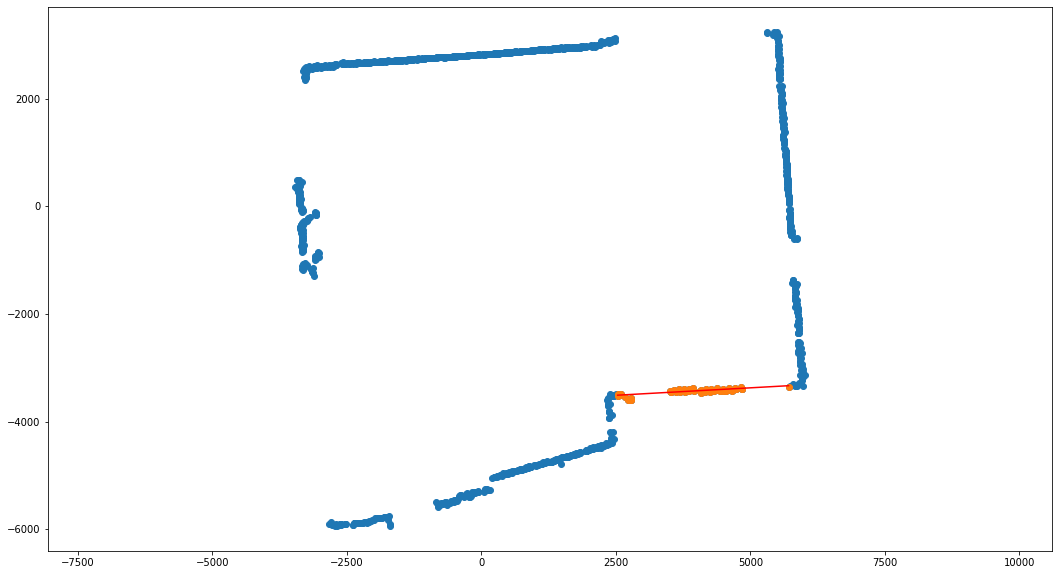

x_span: 3177.366541, y_span: 176.474347


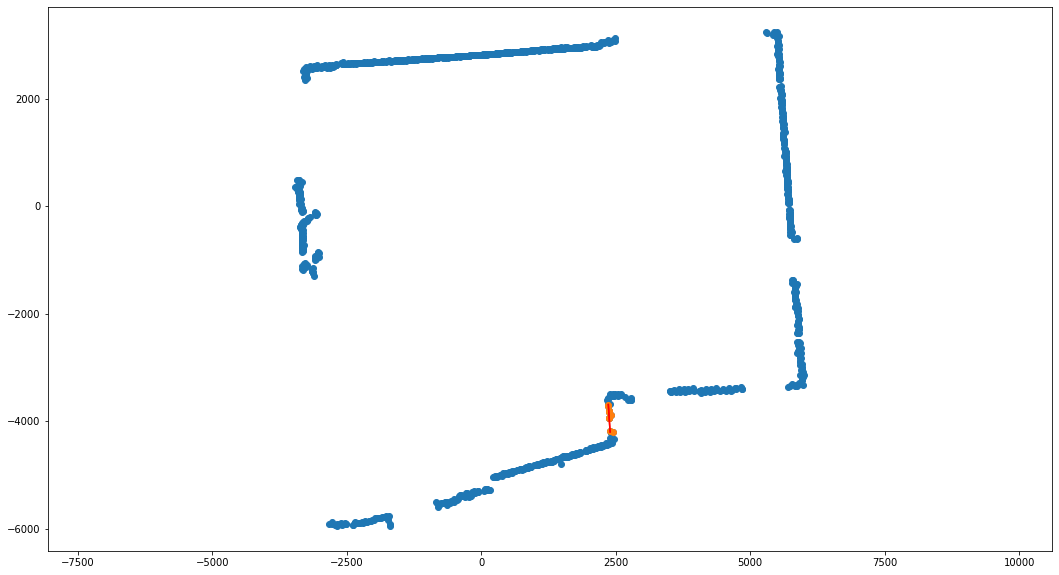

x_span: 32.842759, y_span: 508.953514


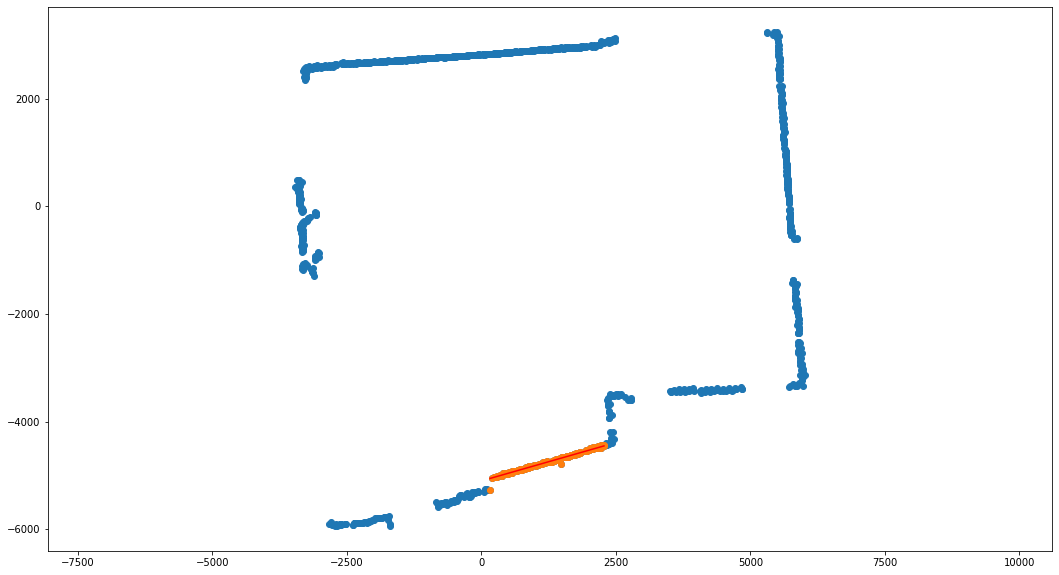

x_span: 2116.831439, y_span: 604.354974


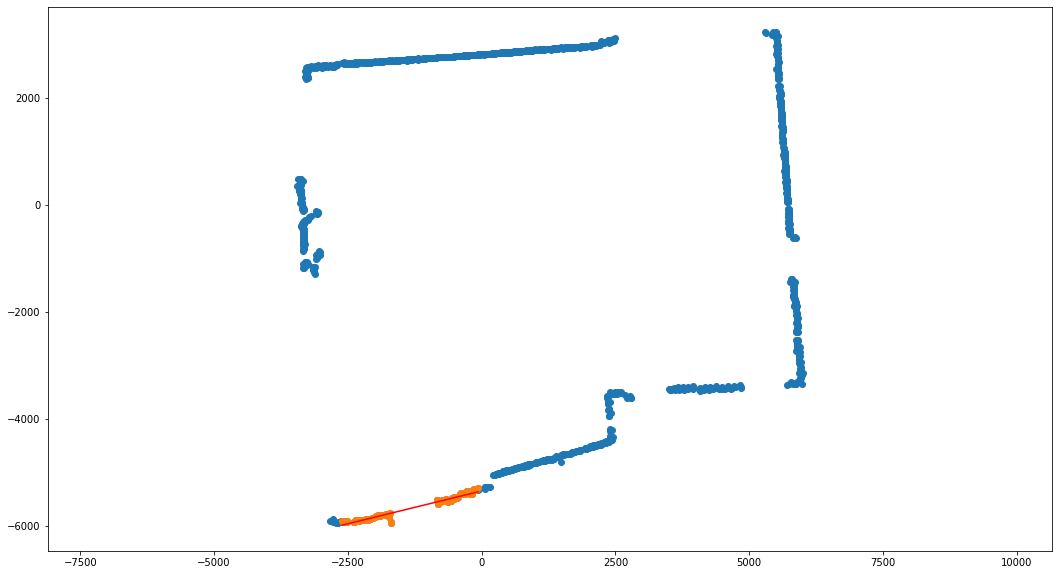

x_span: 2540.926113, y_span: 622.638519


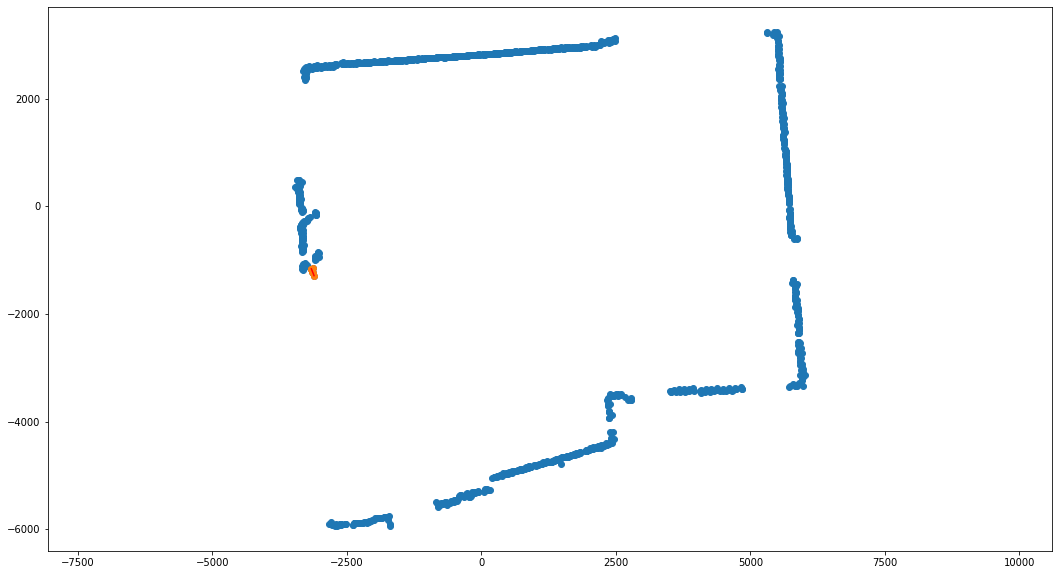

x_span: 49.550324, y_span: 127.336998


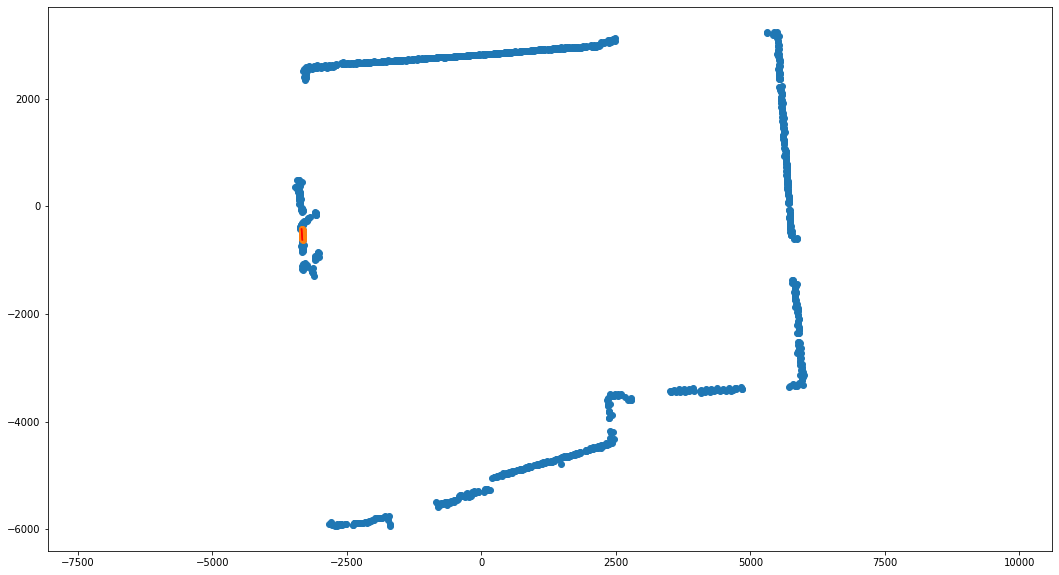

x_span: 14.973287, y_span: 195.324822


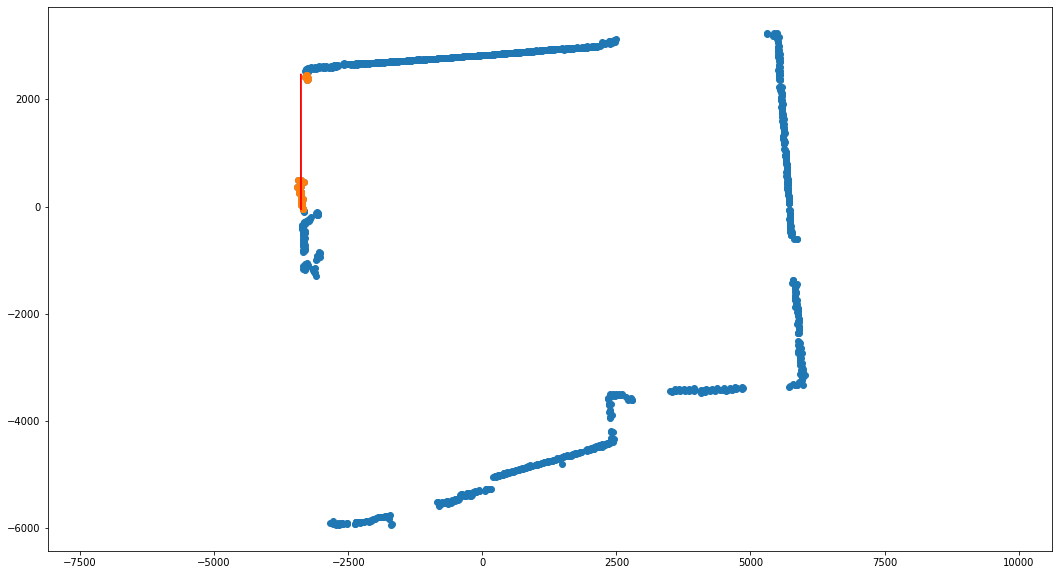

x_span: 1.619998, y_span: 2510.825551


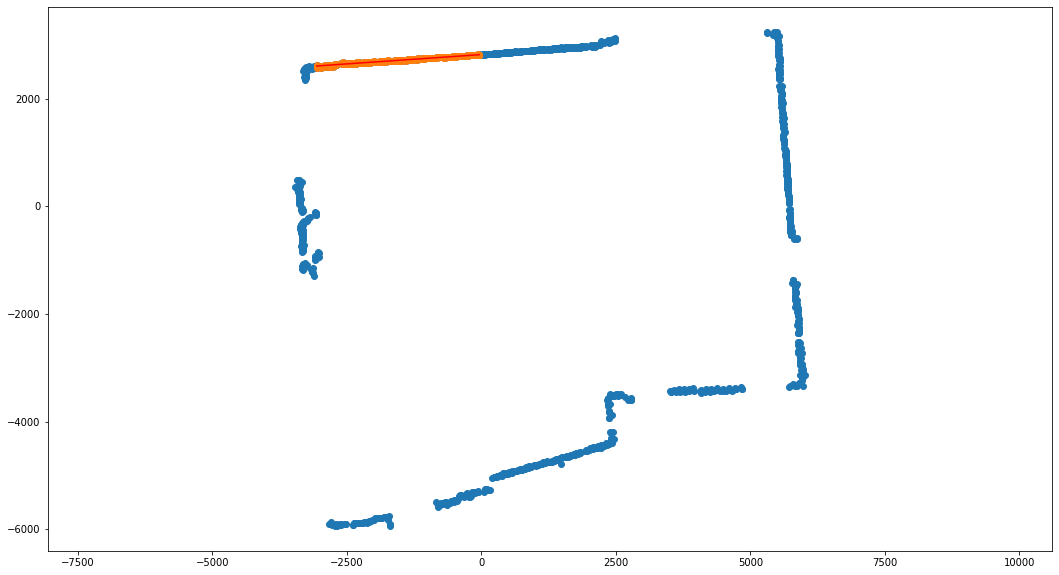

x_span: 3022.149788, y_span: 209.376460


In [43]:
# recompute walls in stable regions
wall_lines = compile_walls(trans_slide, ld2.x, ld2.y, verbose=True)

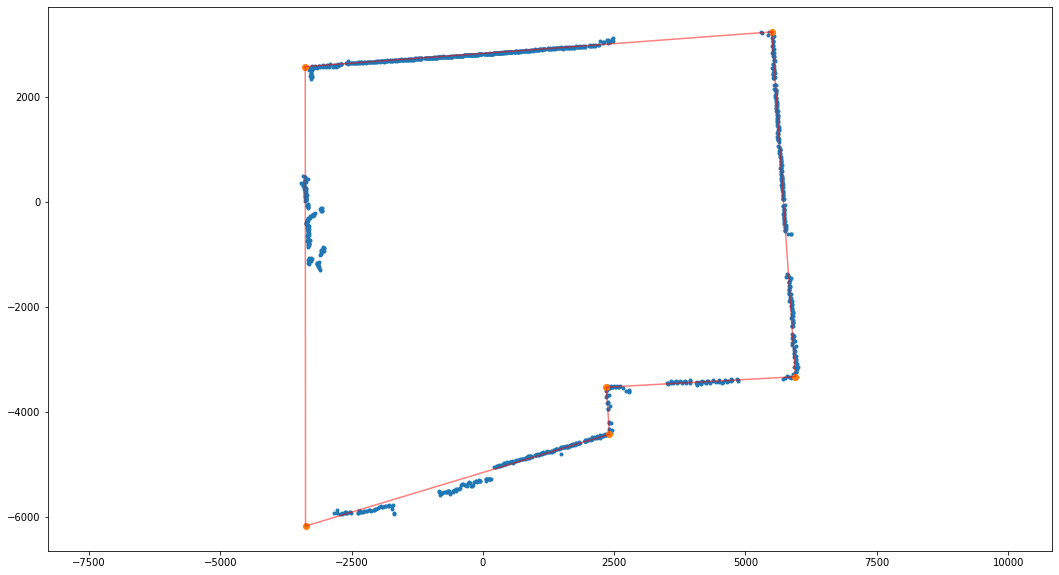

In [44]:
# find corners from walls
sects = get_wall_corners(wall_lines)
plot_corners(sects, ld2.x, ld2.y)

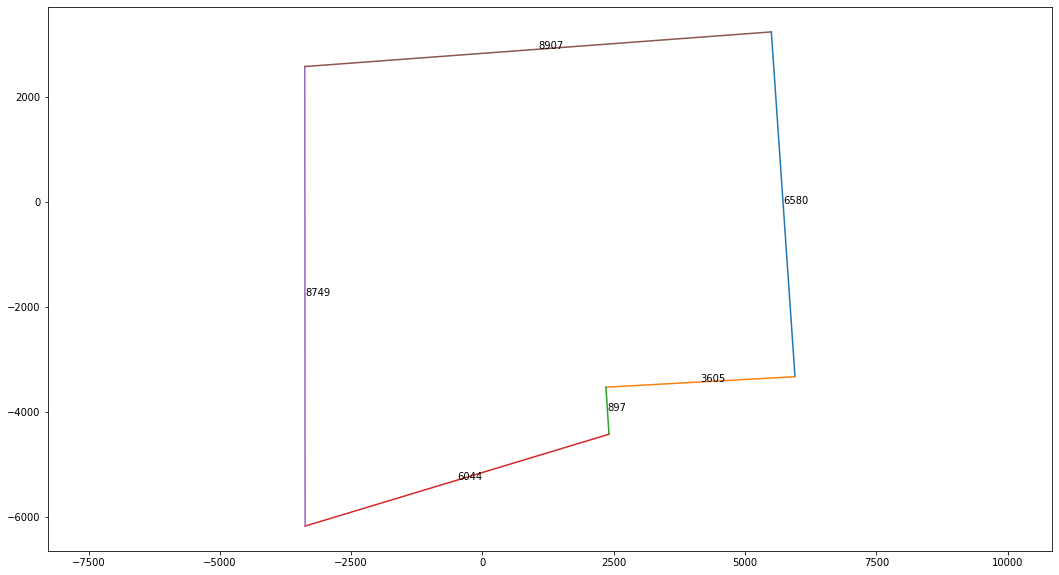

Wall length: 34785.050785


In [45]:
# get floor plan
lengths = compute_wall_lengths(sects, verbose=True)
print('Wall length: %f' % np.sum(lengths))

In [46]:
# total area
area = compute_polygon_area(sects[:,0], sects[:,1])
print('Floor area: %f' % area)

Floor area: 68578391.914350
